In [1]:
import os.path as op
import sys
sys.path.append(op.abspath('../../'))

sys.path.append(op.abspath('../../../../'))

from os import environ
environ["ANAROOT"] = op.abspath('../../../../')

# Clustering with few variables in data : Signal vs Noise

The purpose of this notebook is to perform clustering using only a few variables (instead of the brute-force approach of feeding the clustering algorithm with the 32 samples). In the notebook `look_for_other_columns.ipynb`, we have come up with two new features `mean_before_end_peak` and `mean_after_end_peak`, that seem to be discriminative enough.

The clustering is performed on data, and the peaked background is removed before clustering.

## Libraries

In [2]:
import itertools

import numpy as np

from lib import plot as lp, rootdata as lrd, data, clustering

from project import defs, files, col
from project.defs import dict_color_clu_labels

import hdbscan


In [4]:
randomise_discretisation = False

## Load ROOT file

In [5]:
config_name = "BDT_SN"
file_path = files.get_path_processed_root(config_name)

In [7]:
list_voi = [
    'pos_max', 'pos_min',
    'std', 'pedestal',
    'std_pos', 'std_neg',
    'max', 'min', 'mean',
    'median', 
    'mid'
]

columns = [
    'mean_m_pedestal',
    'min_m_pedestal',
    'max_m_pedestal',
    'min_std_pos_neg',
    'max_std_pos_neg',
    'min_std_pos_neg_red',
    'max_std_pos_neg_red',
    'min_std_pos_neg_redpn',
    'max_m_mean',
    'max_m_mean_red',
    'min_m_mean', 'min_m_mean_red',
    "mid_m_mean", "mid_m_mean_red",
    "median_m_mean", "median_m_mean_red"
]

other_columns = [
    'mean_before_end_peak', 'mean_after_end_peak', 
    'pos_first_neg_after_max', "nb_peaks_sup_80_wrt_min",
    "best_chi2"
]
columns += ['mean_before_end_peak_red', 'mean_after_end_peak_red']

In [8]:
dataframe, column_labels = files.load_and_process_dataframe(
    file_path, list_voi, columns, other_columns,
    branches=defs.list_samples_columns+["eta", "phi"],
    rd=randomise_discretisation,
    verbose=True
)


Time taken to load the ROOT files: 15.311838150024414
ROOT files loaded: /mnt/d/900GeV/processed/simulation/BDT_SN.root
COMPUTE VOIs
Time taken to compute the voi: 6.795197486877441
COMPUTE COLUMNS (not already computed)
Time taken to compute the voi: 5.852638006210327
Time taken to compute the columns: 42.09792137145996


In [9]:
dataframe = dataframe.query("std!=0")
dataframe = dataframe.query("max - min <= 3")


In [11]:
column_labels_computed  = col.get_formula_labels(
    columns, column_labels
)

column_labels = {**column_labels, **column_labels_computed}

### New variables

### Cuts

In [12]:
from scripts.clustering import data_cuts
data_cuts.apply_signal_cuts(
    dataframe, 
    list_cut_columns=["min_std_pos_neg_redpn"]
)

Cut min_std_pos_neg_redpn > 0.02 -> efficiency 0.5063044507157728


In [ ]:
min_std_pos_neg_redpn 

### Checking plots

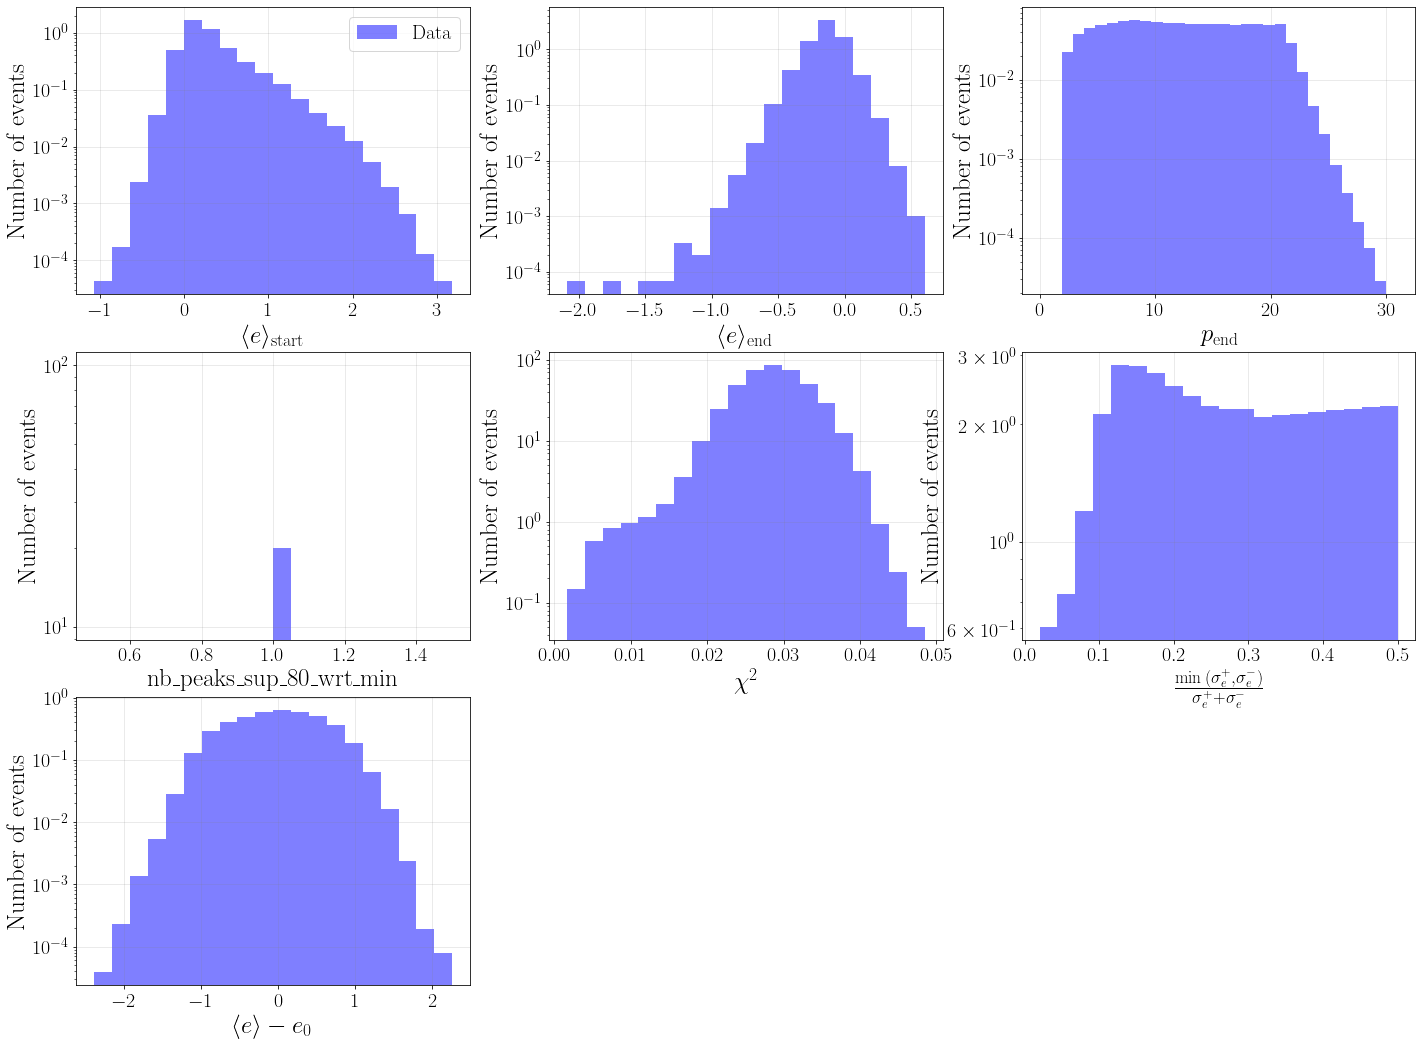

In [38]:
fig, axes = lp.multi_plot_hist(
    [dataframe], 
    other_columns + ["min_std_pos_neg_redpn", "mean_m_pedestal"],
    column_labels,
    list_colors=['b'],
    list_labels=['Data'],
    logscale=True,
    nbins={
        'default': 20,
        'pos_first_neg_after_max': 32
    },
    range_columns={
        'default': 20,
        'pos_first_neg_after_max': [0, 31]
    }
)

## Interesting features

/home/anthony/3A_CS/projet_ATLAS/lib/plot.py:303: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8, 6))


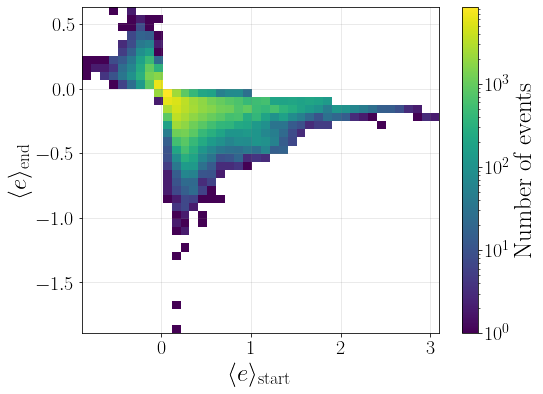

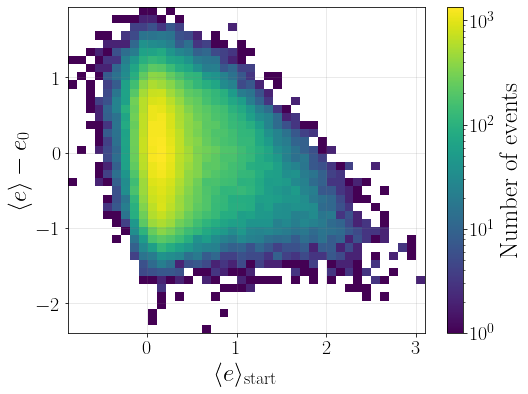

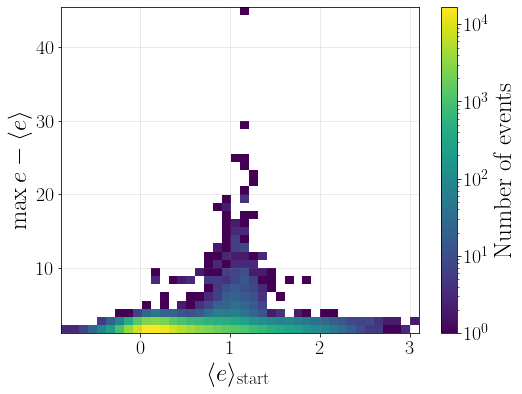

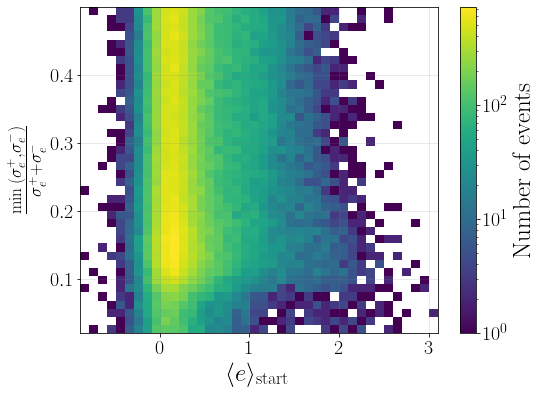

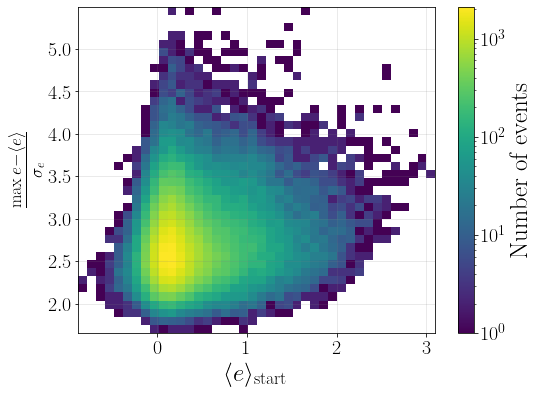

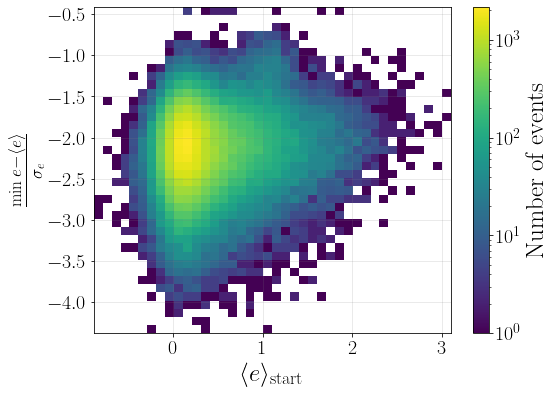

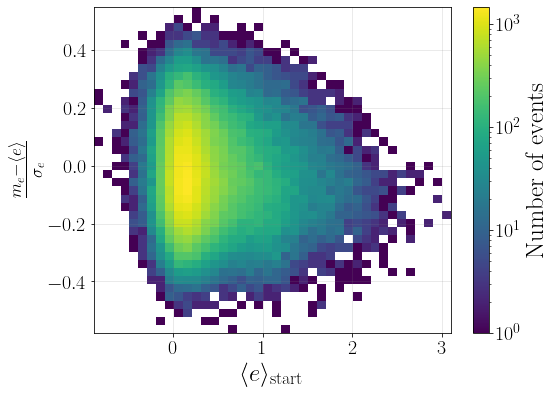

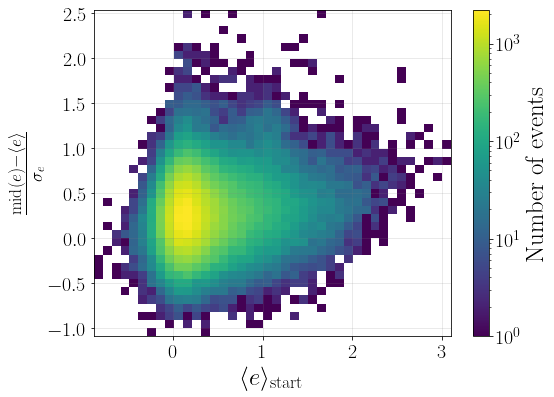

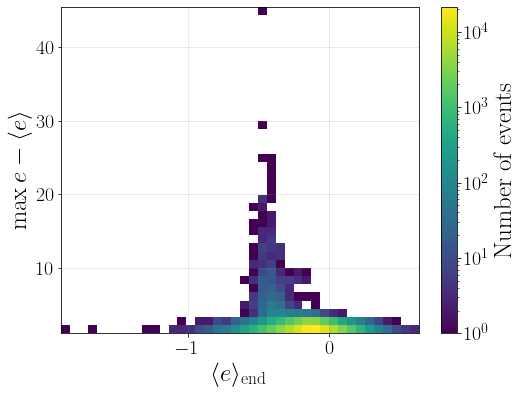

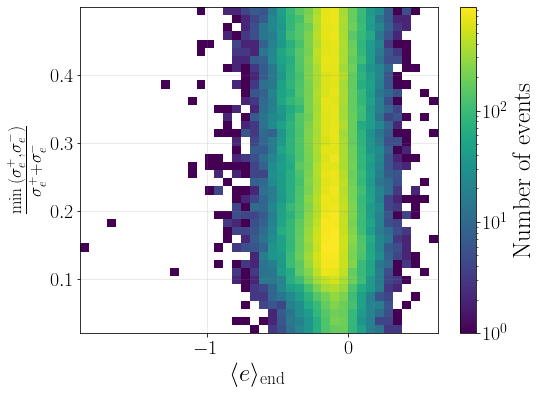

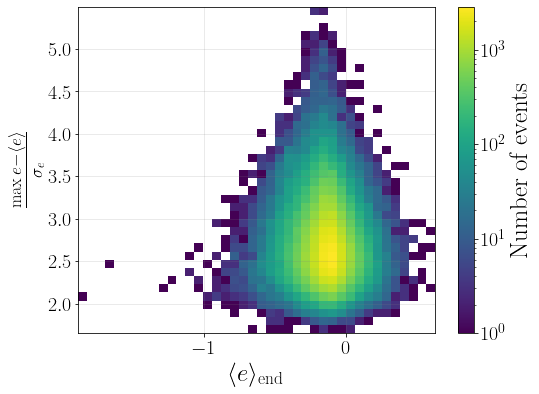

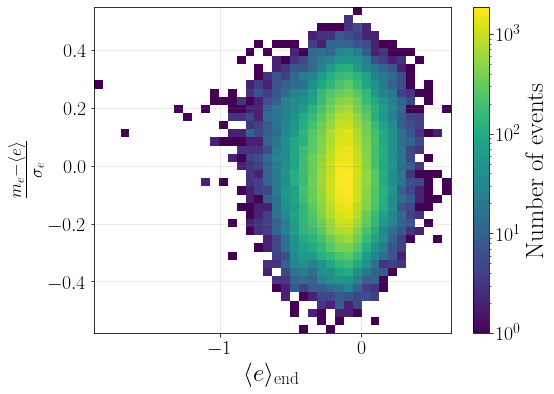

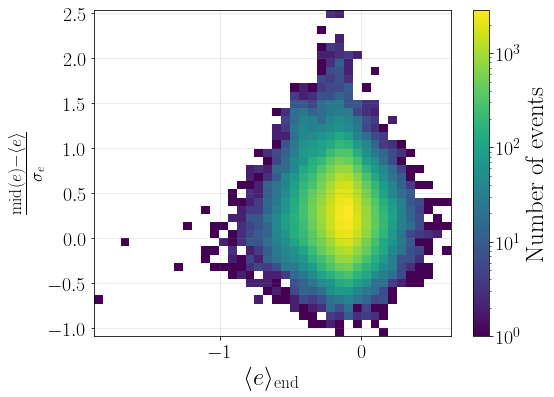

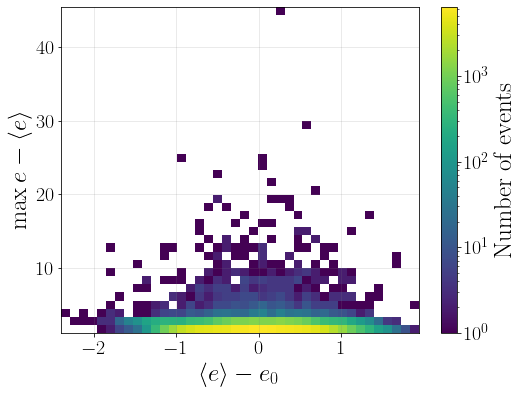

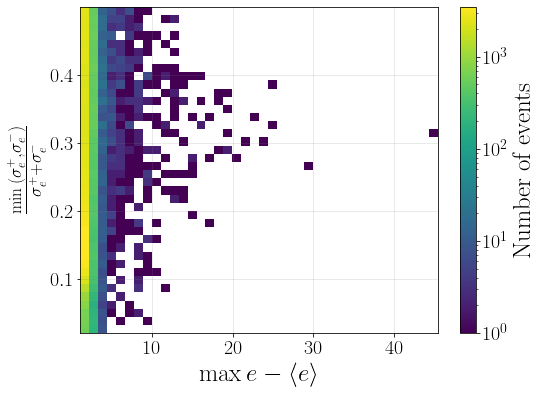

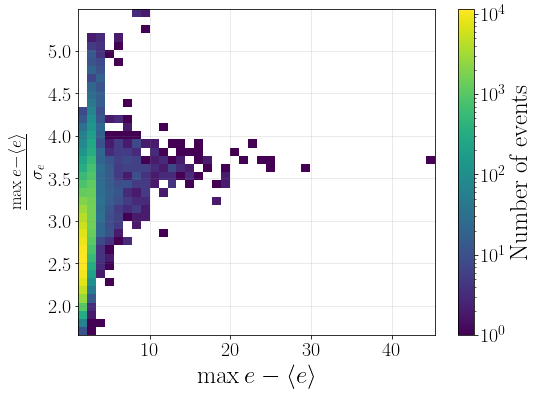

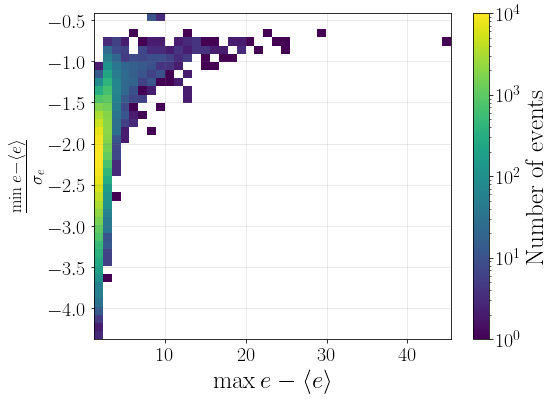

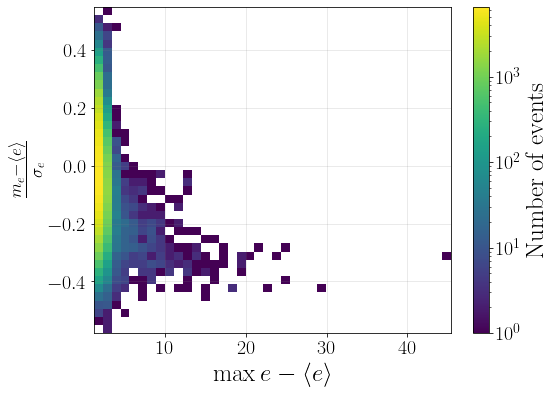

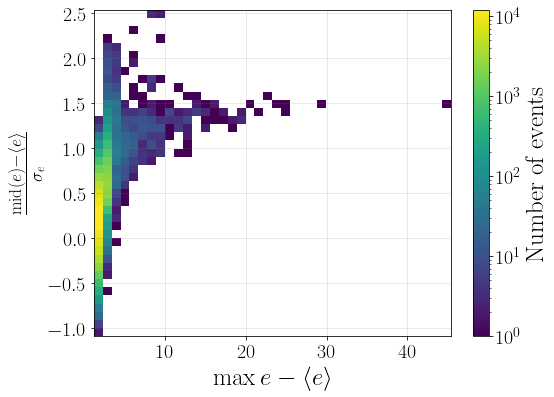

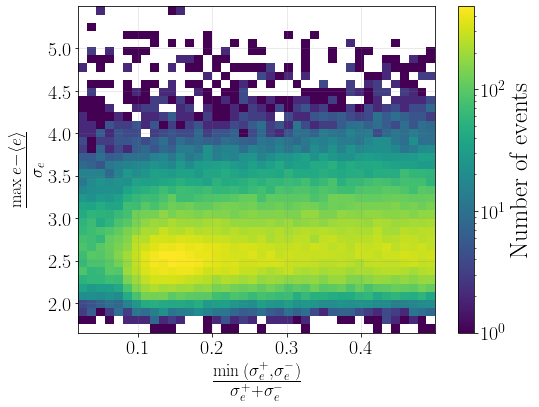

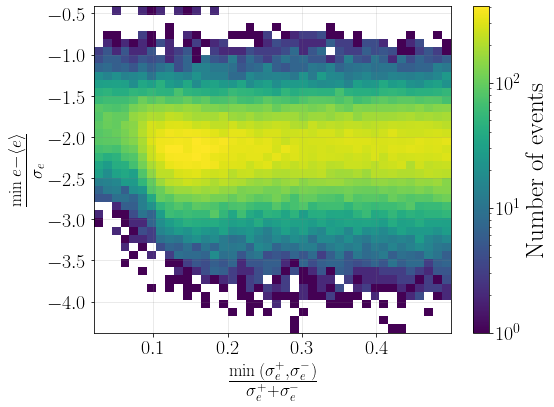

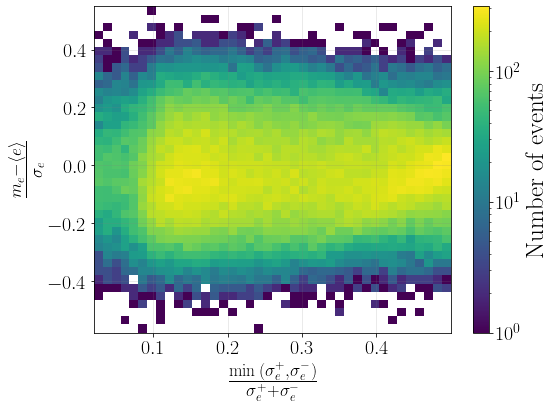

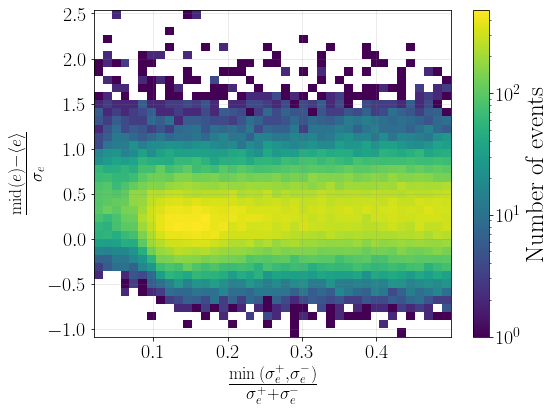

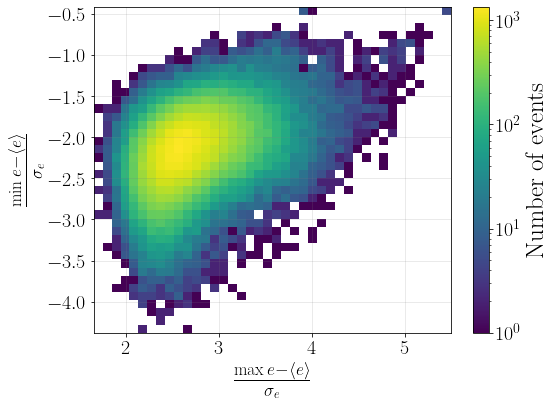

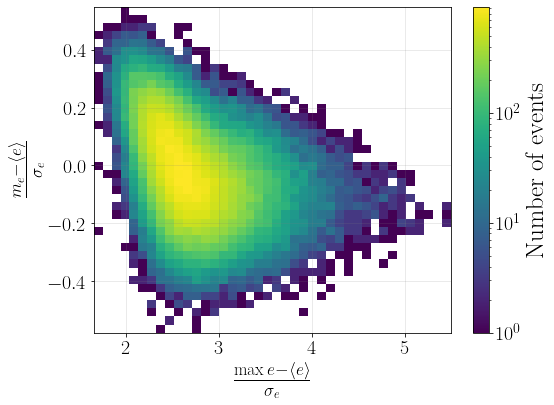

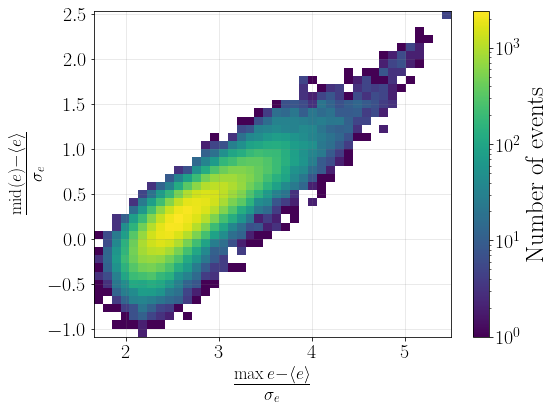

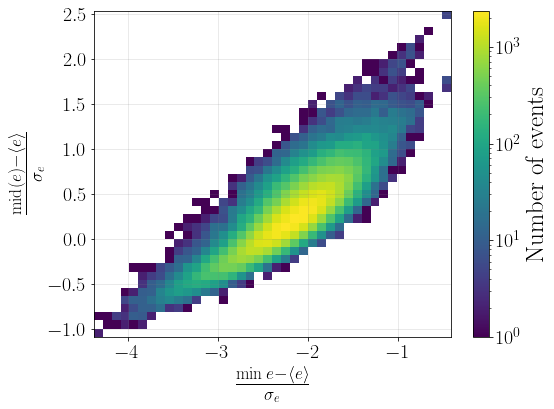

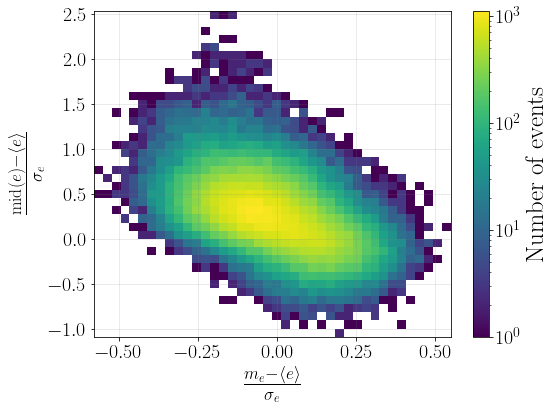

In [19]:
interesting_features = [
    "mean_before_end_peak", "mean_after_end_peak", "mean_m_pedestal", "max_m_mean", "min_std_pos_neg_redpn",
    "max_m_mean_red", "min_m_mean_red",
    "median_m_mean_red", "mid_m_mean_red"
]

from project.defs_range import column_ranges, column_nbins

for name_var1, name_var2 in itertools.combinations(interesting_features, 2):
    min_max = [None, None]
    bins = [None, None]

    if name_var1 in column_ranges:
        min_max[0] = column_ranges[name_var1]
    if name_var2 in column_ranges:
        min_max[1] = column_ranges[name_var2]

    bins[0] = column_nbins.get(name_var1, column_nbins['default'])
    bins[1] = column_nbins.get(name_var2, column_nbins['default'])

    if bins==[None, None]:
        bins = None


    lp.plot_hist2d(
        dataframe[name_var1], dataframe[name_var2],
        column_labels[name_var1], column_labels[name_var2],
        logscale=True,
        min_max=min_max,
        bins=bins

    )

## Clustering - Signal vs Noise

In [20]:
rng = np.random.default_rng(12345)

### HDBSCAN

In [21]:
import hdbscan

In [22]:
clu_label_name = "HDBSCAN"
clu_label_alias = "HDBSCAN"


In [46]:
features = [
    "mean_before_end_peak_red", "mean_after_end_peak_red", #"max_m_mean",
    "max_m_mean_red",
    "min_m_mean_red",
    "mid_m_mean_red",
    "best_chi2" 
    # "min_std_pos_neg_redpn",
    # "mean_m_pedestal",
]

In [47]:
print("Number of event in the dataframe", len(dataframe))

Number of event in the dataframe 110132


In [48]:
clusterer = hdbscan.HDBSCAN(
    algorithm='best', 
    metric='euclidean',
    min_cluster_size=20,
    min_samples=1,
    # cluster_selection_epsilon=.01,
)

clusterer = clusterer.fit(dataframe[features])
dataframe[clu_label_name] = clusterer.labels_


The resulting dataframe is saved.

In [42]:
# import uproot4
# from lib.utils import try_makedirs

# output_path = op.join(defs.proc_folder, "clustering")
# full_output_path = op.join(output_path, 
#     f"{config_name}_{clu_label_name}.root")
# try_makedirs(output_path)
# out_file = uproot4.recreate(full_output_path)
# out_file[defs.proc_tree_name] = dataframe_filtered

In [49]:
np.unique(dataframe[clu_label_name])

array([-1,  0,  1,  2,  3])

(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='HDBSCAN', ylabel='Number of events'>)

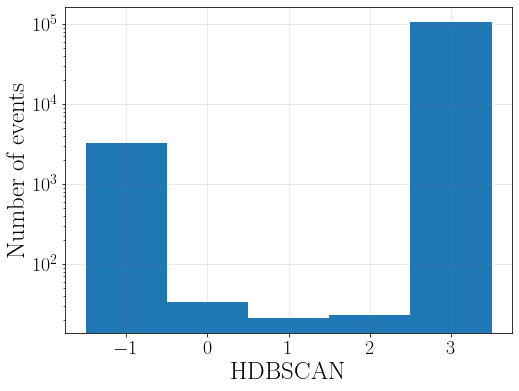

In [50]:
bins = clustering.get_edges_from_clust_labels(
    clusterer.labels_
)

lp.plot_hist(
    dataframe[clu_label_name],
    clu_label_alias,
    logscale=True,
    bins=bins,
)

/home/anthony/3A_CS/projet_ATLAS/lib/plot.py:692: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(


{'mean_before_end_peak_red_mean_after_end_peak_red': (<Figure size 864x432 with 1 Axes>,
  <Figure size 1728x864 with 10 Axes>),
 'mean_before_end_peak_red_max_m_mean_red': (<Figure size 864x432 with 1 Axes>,
  <Figure size 1728x864 with 10 Axes>),
 'mean_before_end_peak_red_min_m_mean_red': (<Figure size 864x432 with 1 Axes>,
  <Figure size 1728x864 with 10 Axes>),
 'mean_before_end_peak_red_mid_m_mean_red': (<Figure size 864x432 with 1 Axes>,
  <Figure size 1728x864 with 10 Axes>),
 'mean_before_end_peak_red_best_chi2': (<Figure size 864x432 with 1 Axes>,
  <Figure size 1728x864 with 10 Axes>),
 'mean_before_end_peak_red_max_m_mean': (<Figure size 864x432 with 1 Axes>,
  <Figure size 1728x864 with 10 Axes>),
 'mean_after_end_peak_red_max_m_mean_red': (<Figure size 864x432 with 1 Axes>,
  <Figure size 1728x864 with 10 Axes>),
 'mean_after_end_peak_red_min_m_mean_red': (<Figure size 864x432 with 1 Axes>,
  <Figure size 1728x864 with 10 Axes>),
 'mean_after_end_peak_red_mid_m_mean_red':

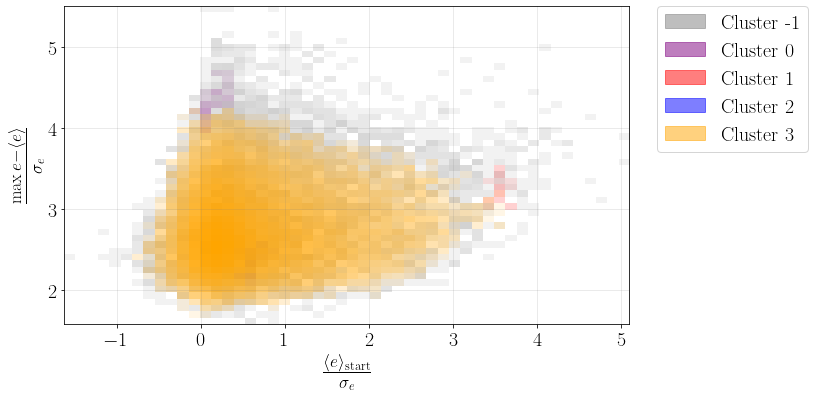

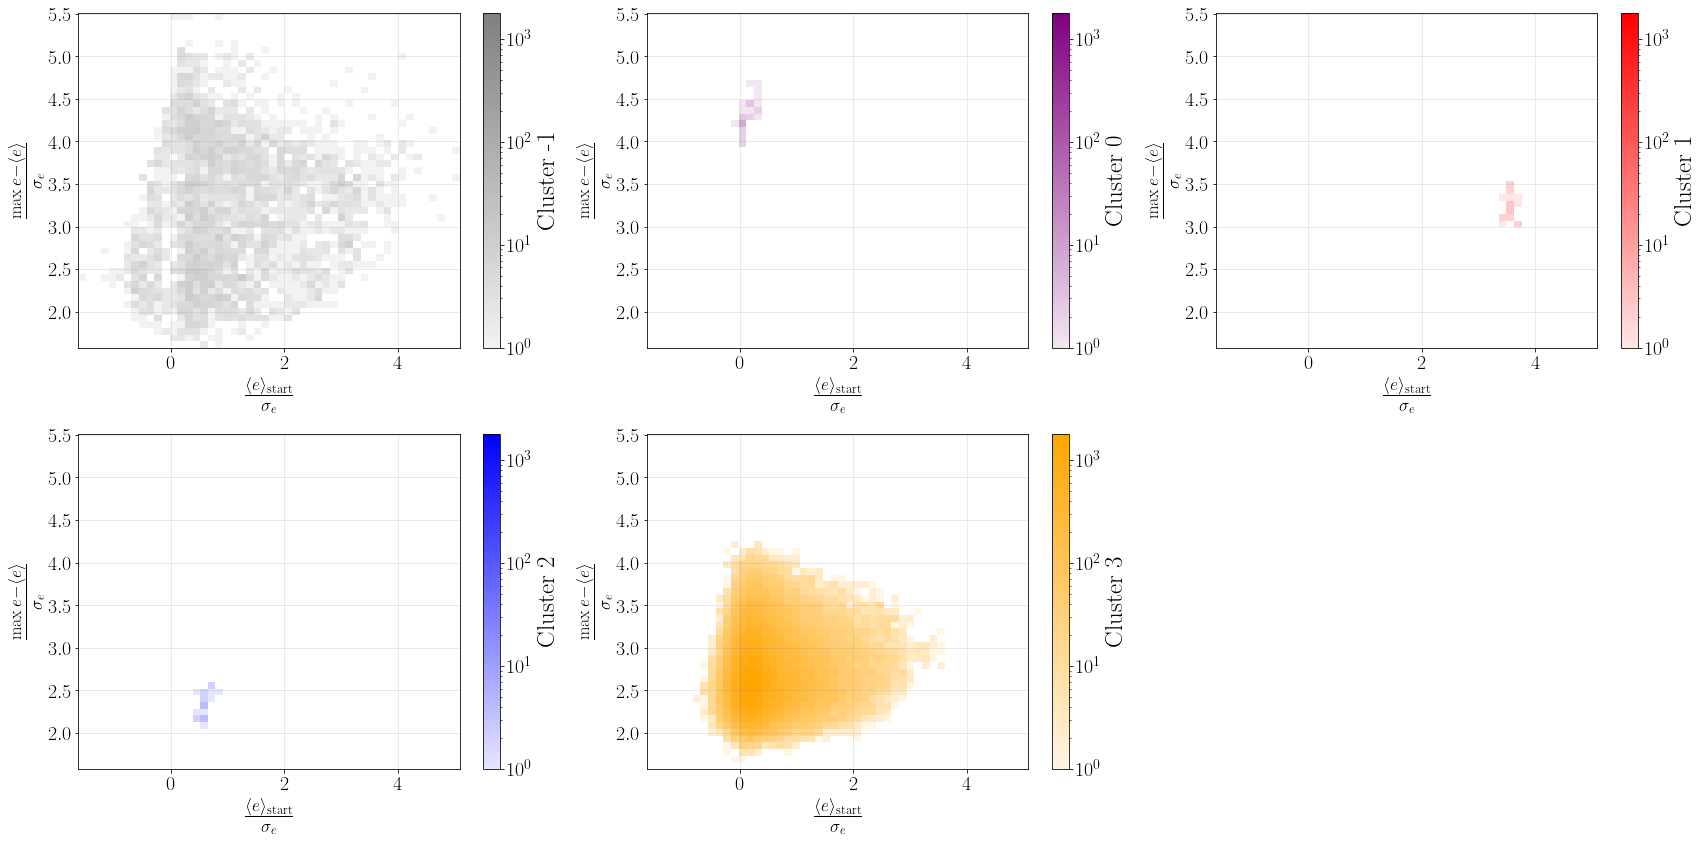

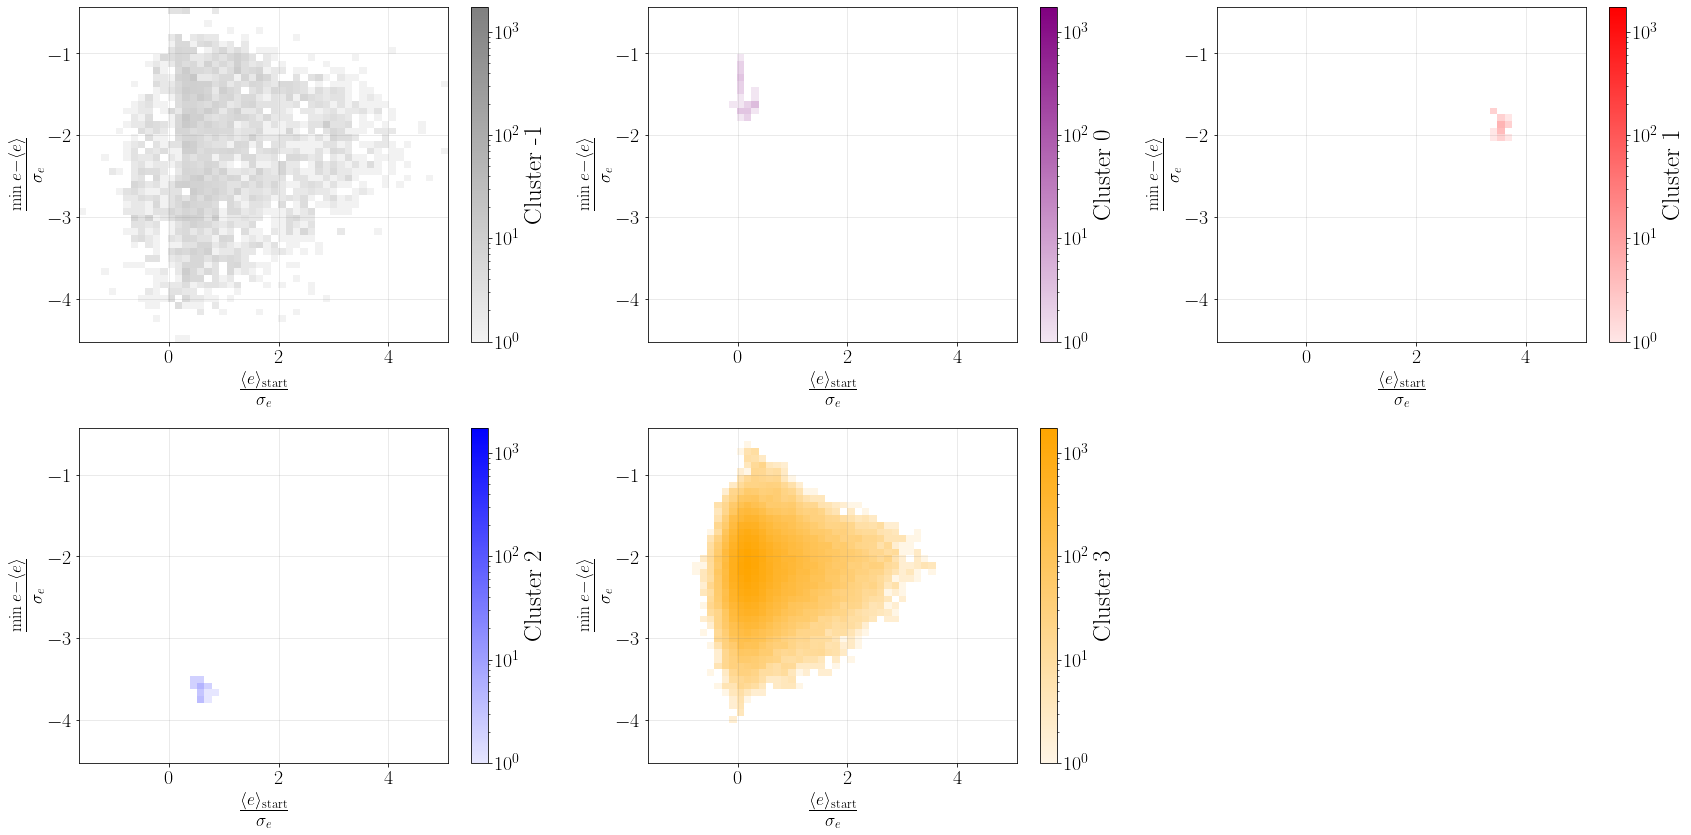

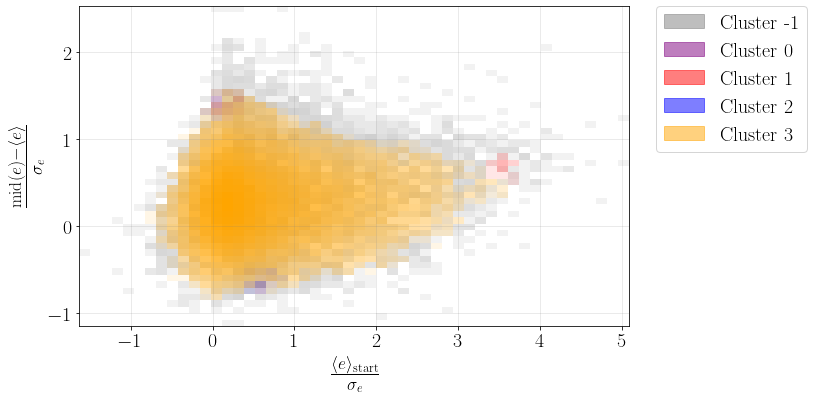

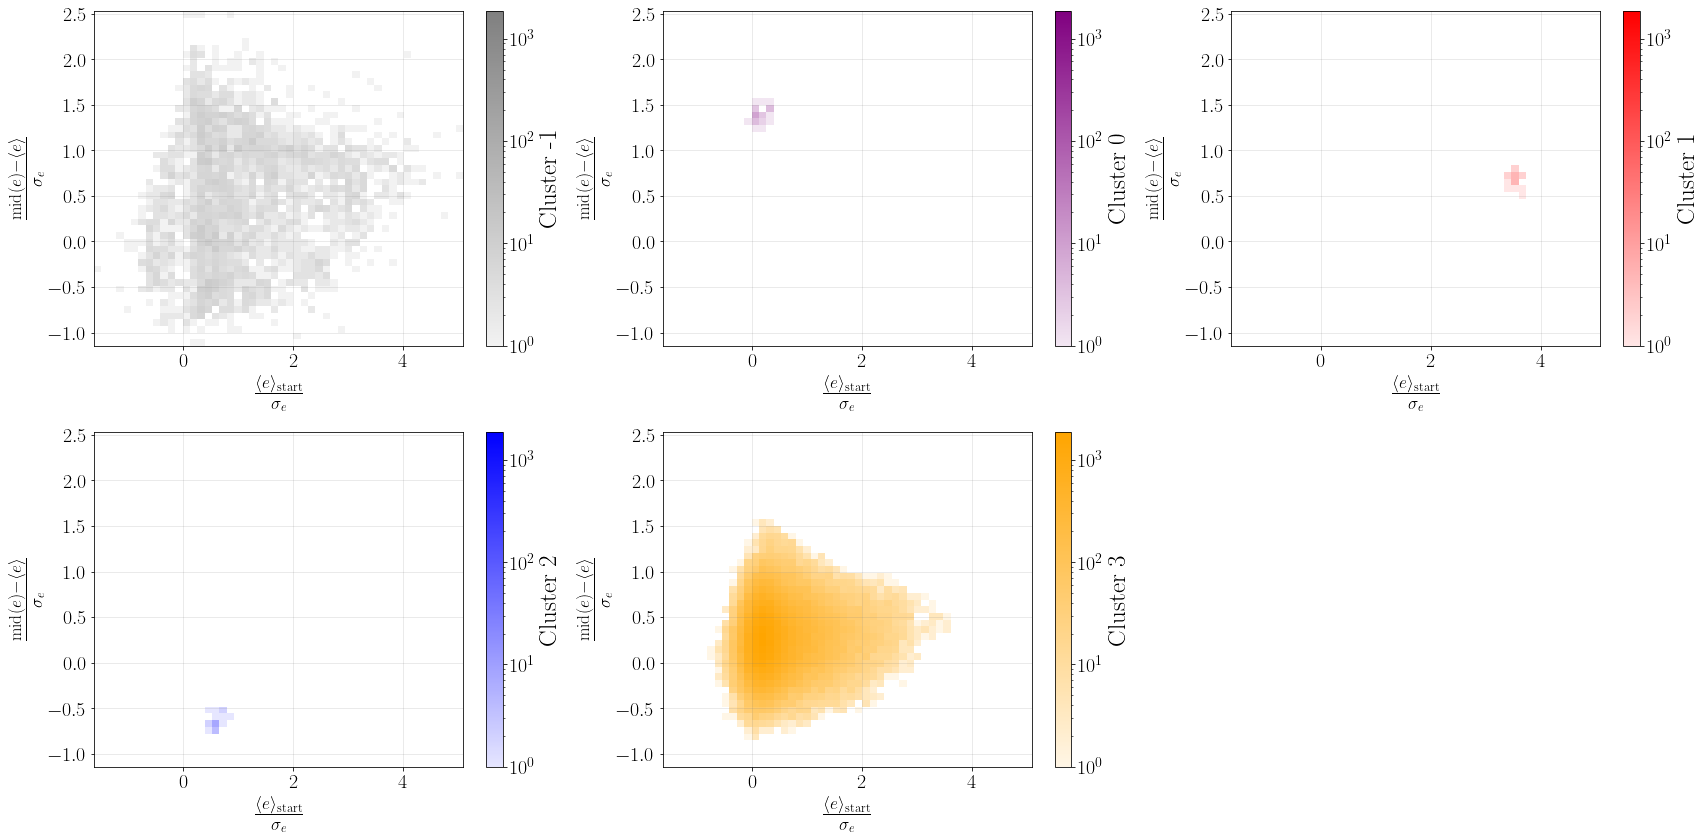

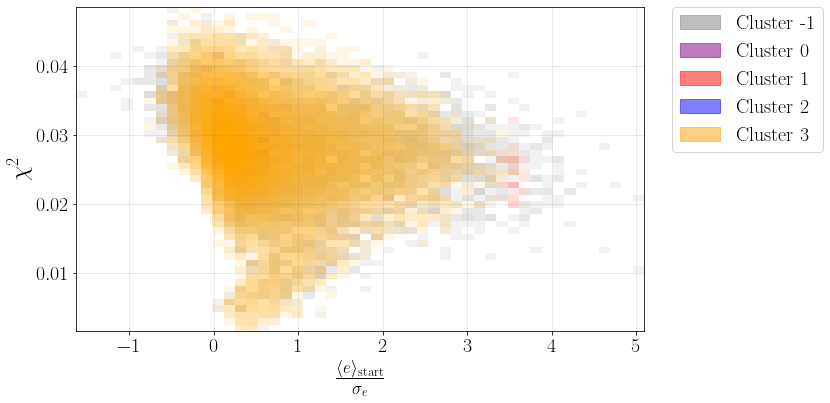

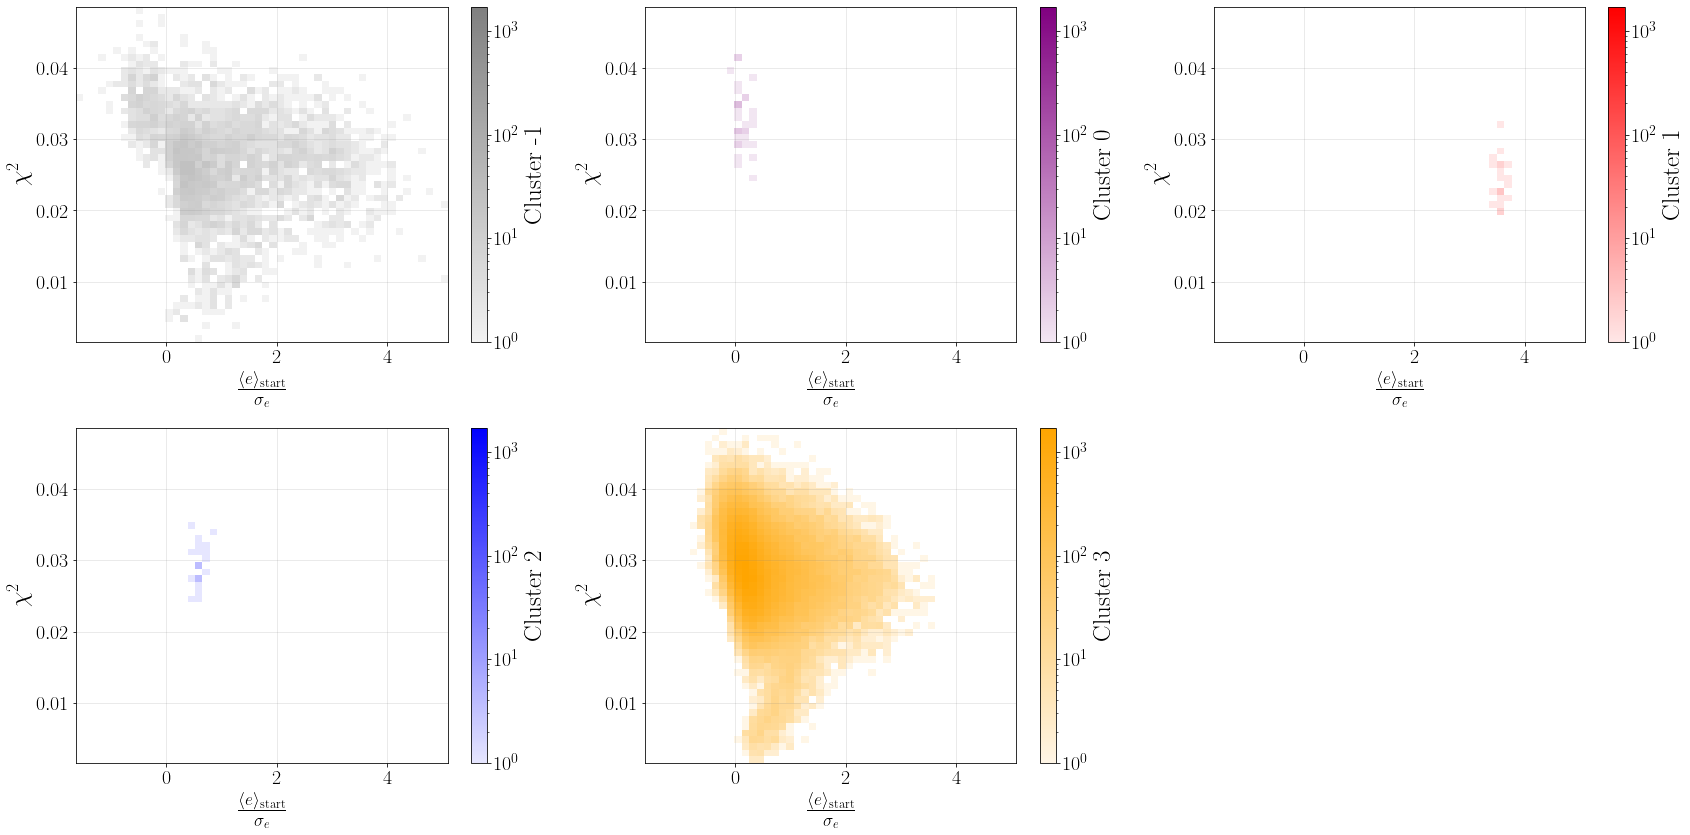

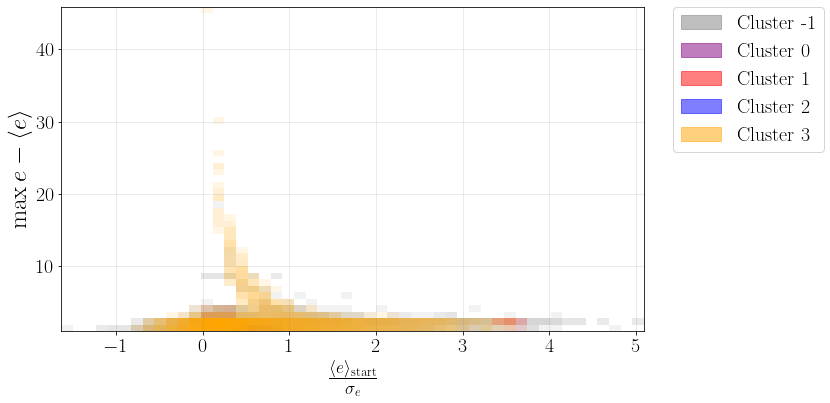

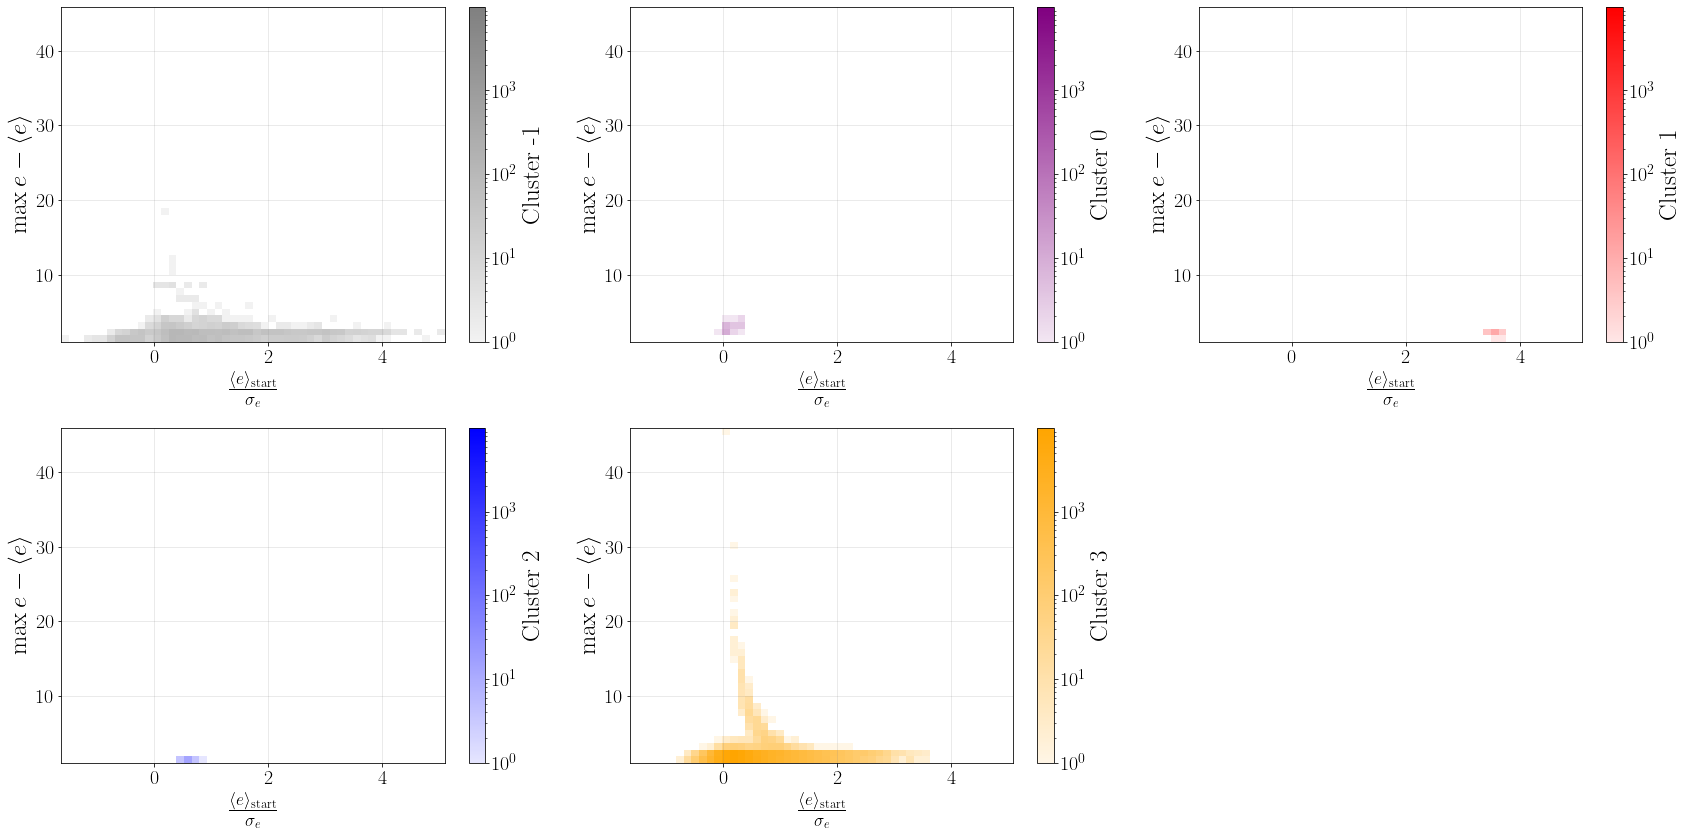

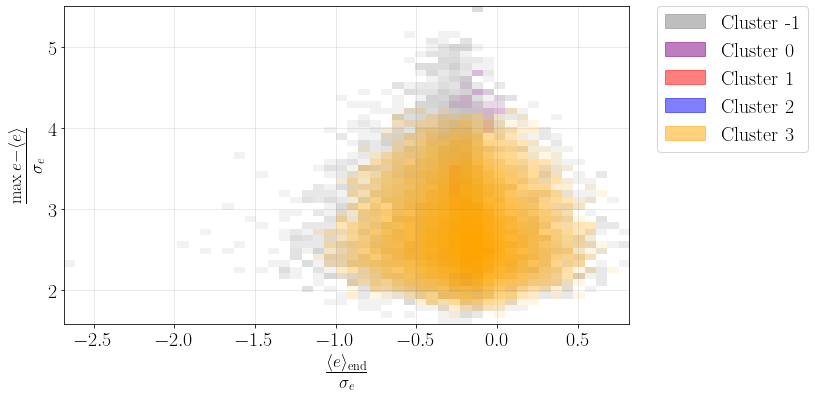

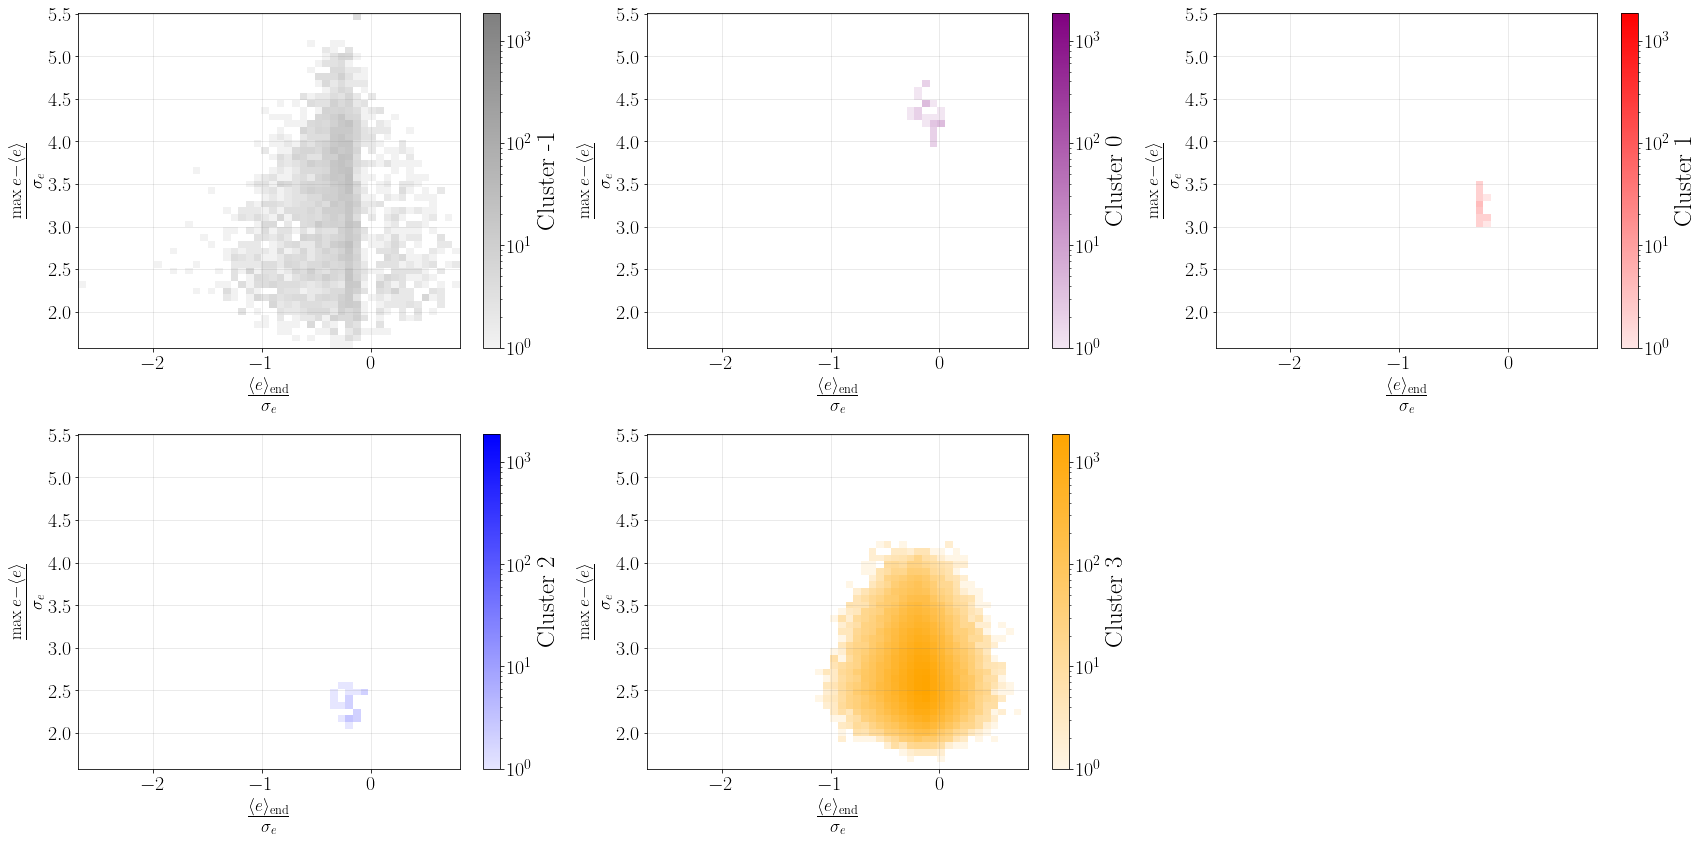

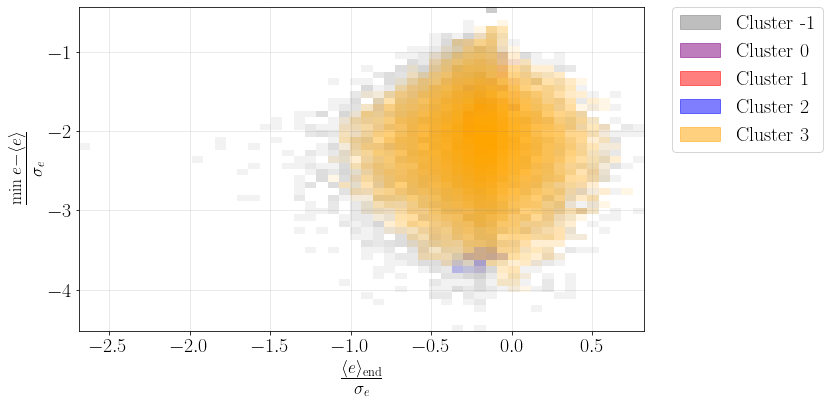

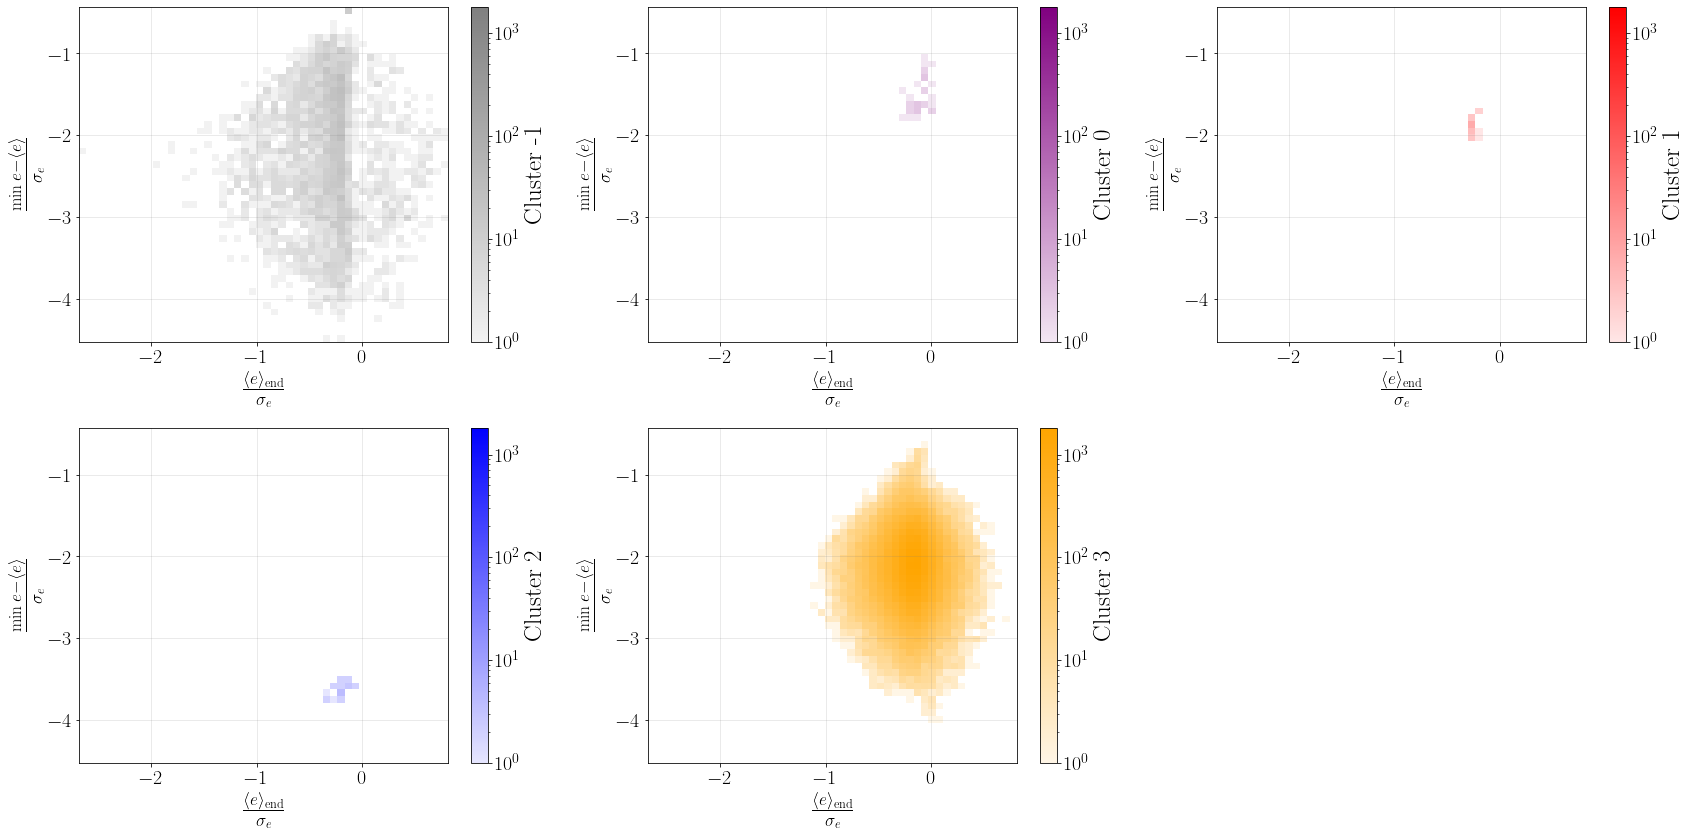

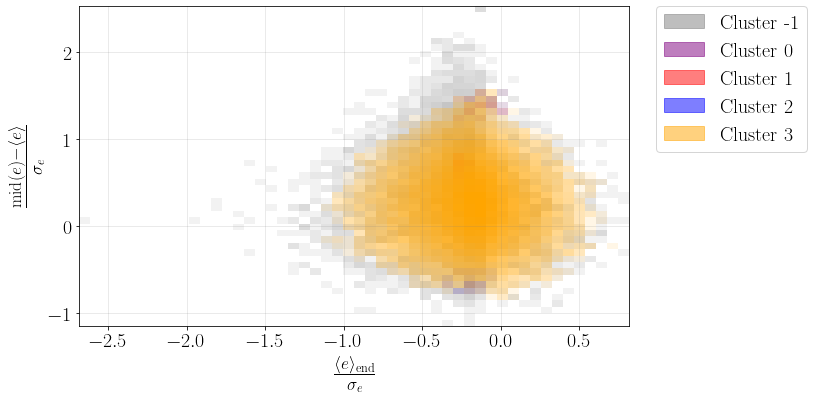

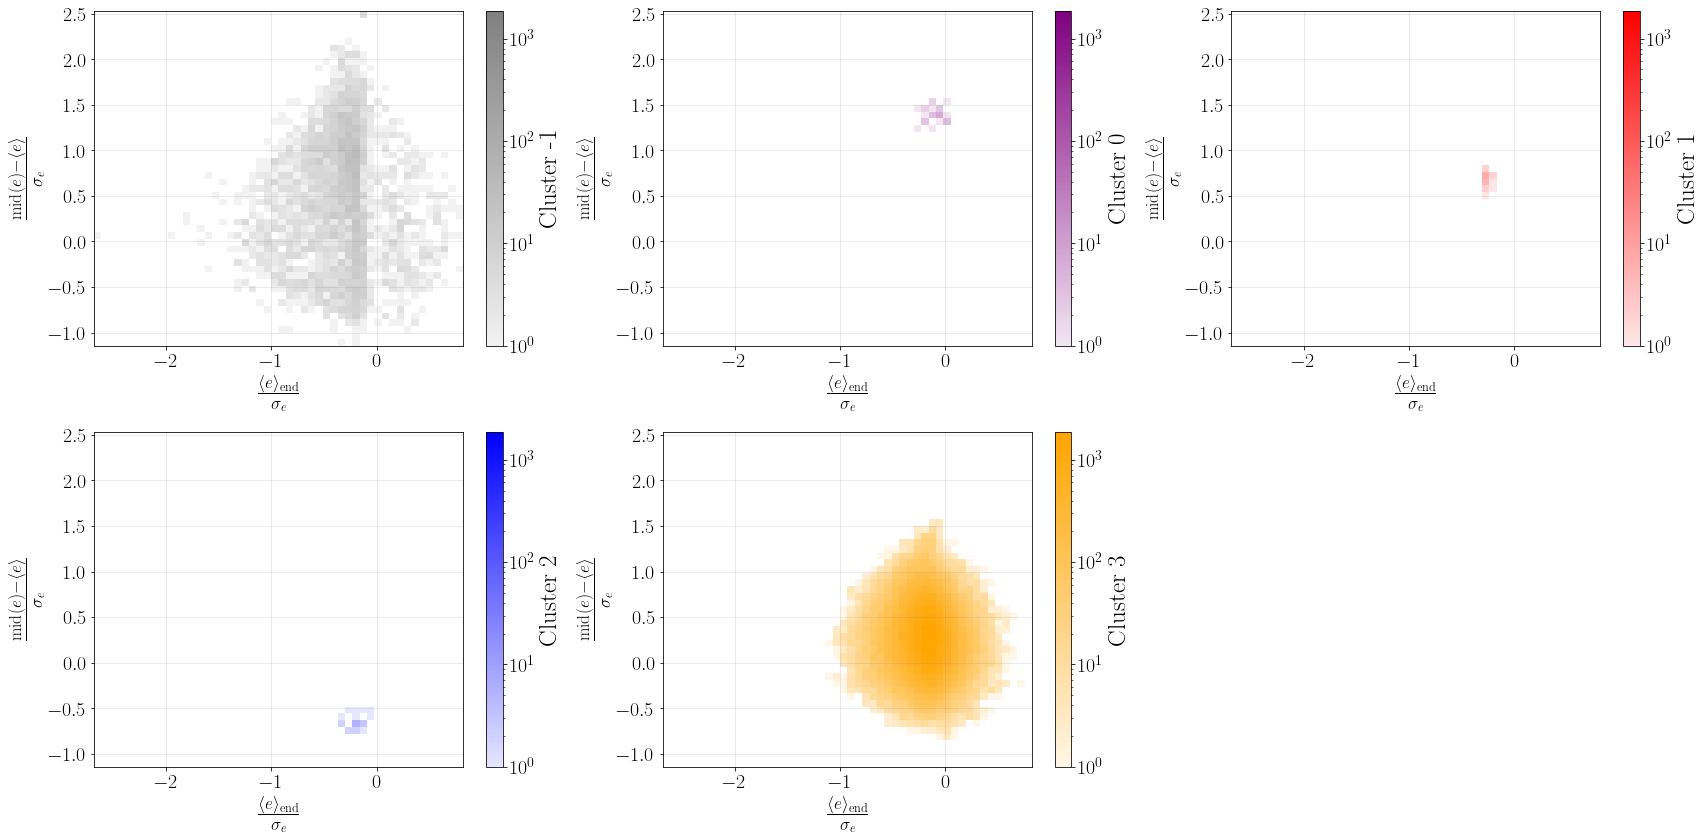

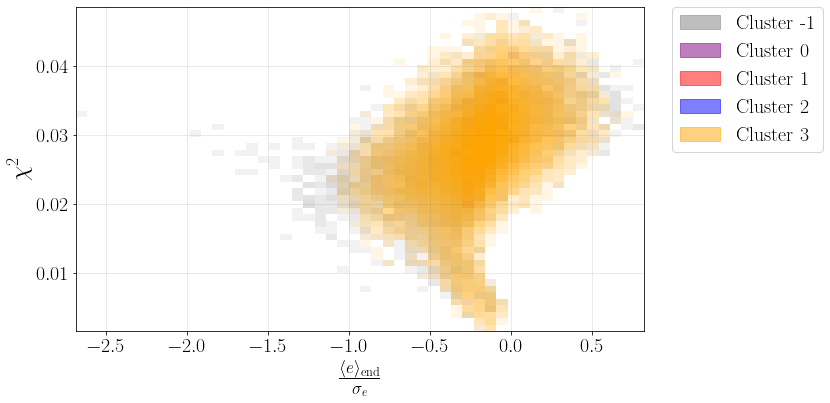

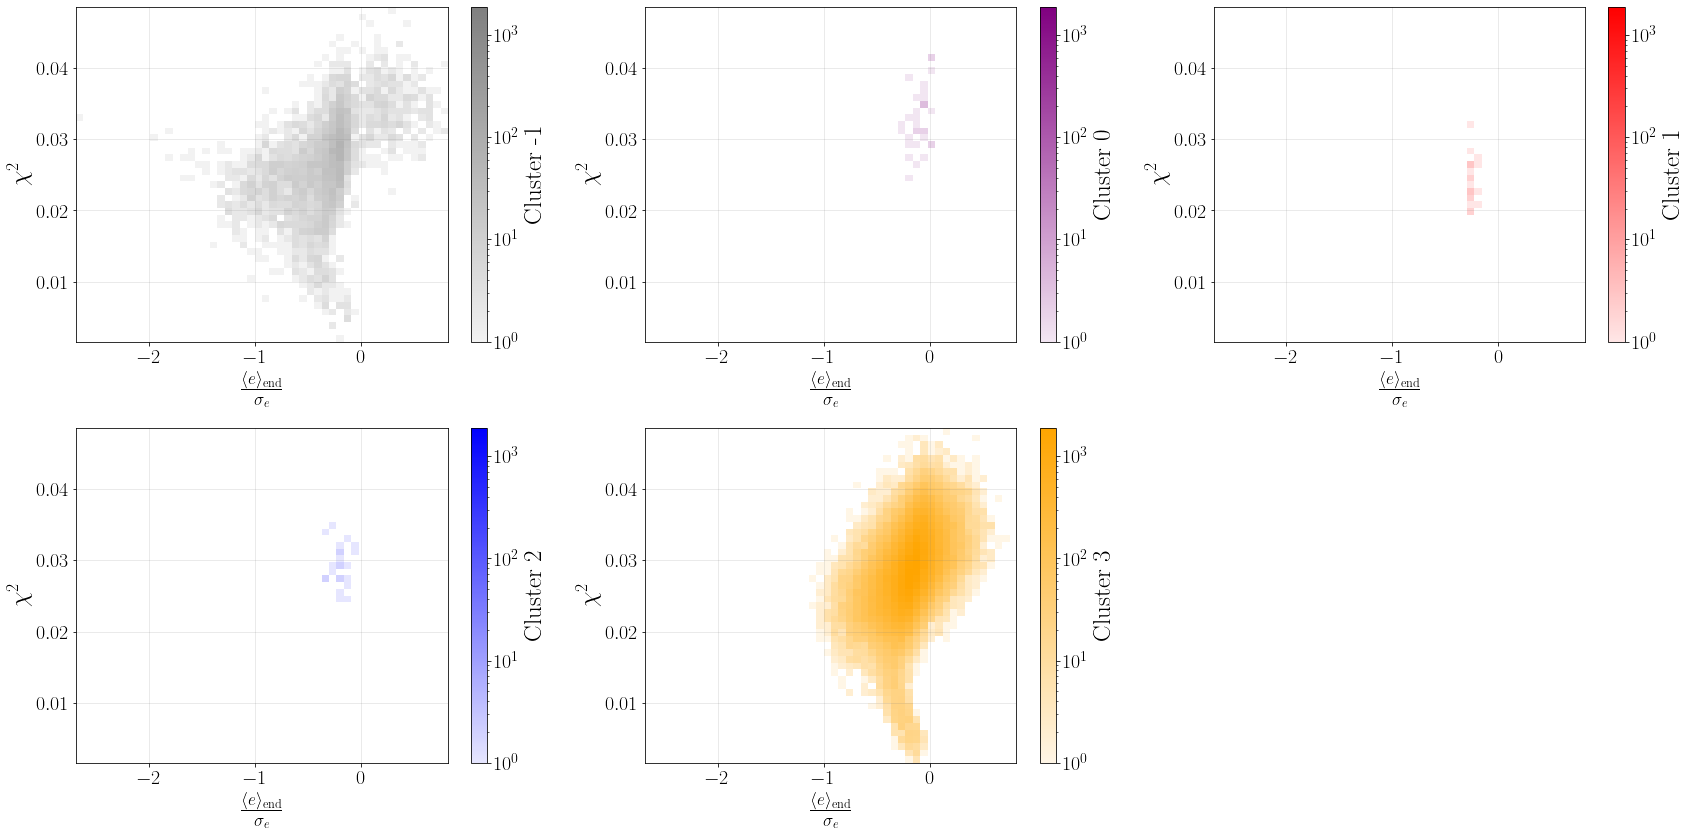

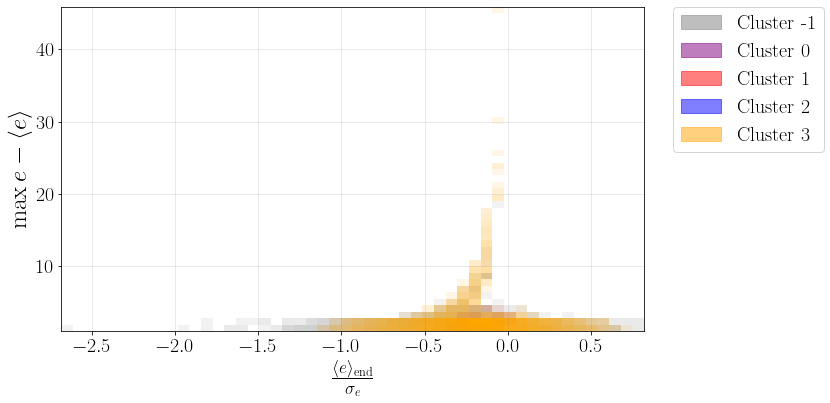

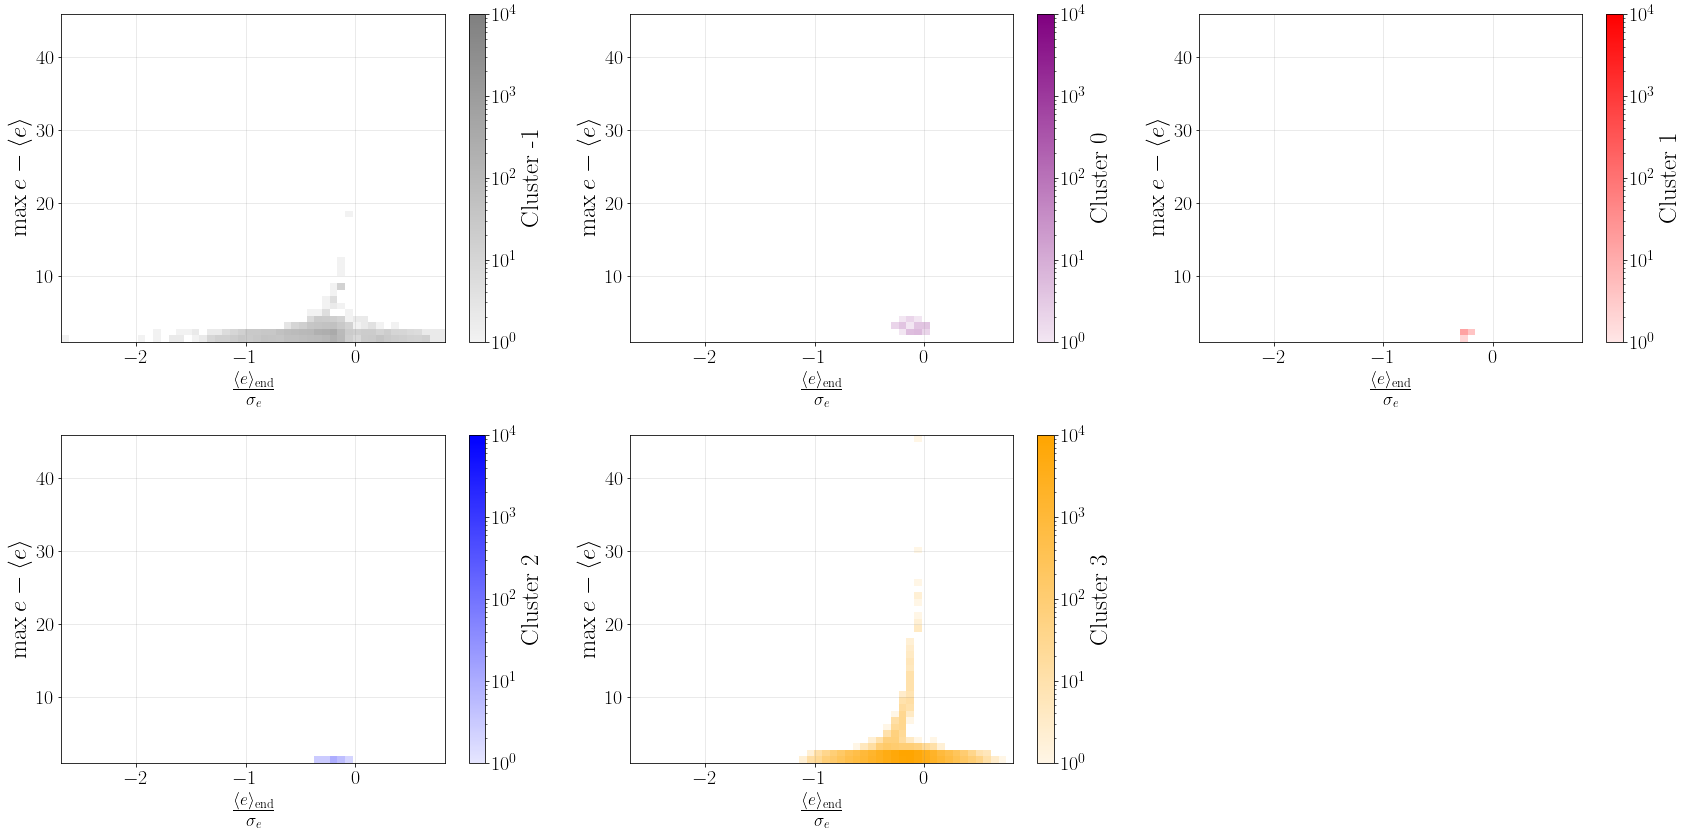

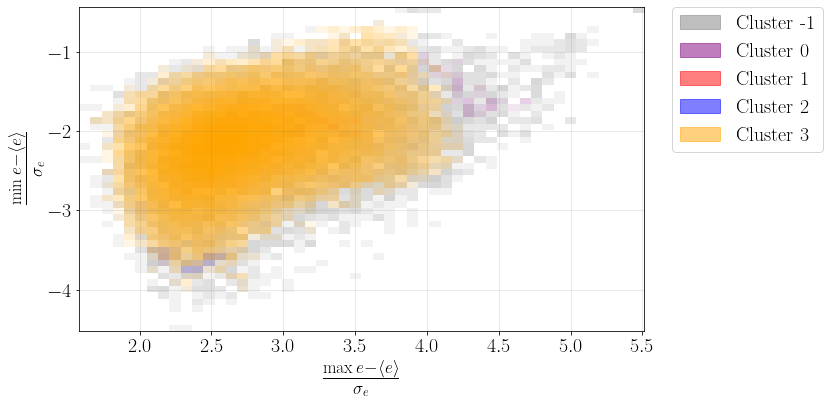

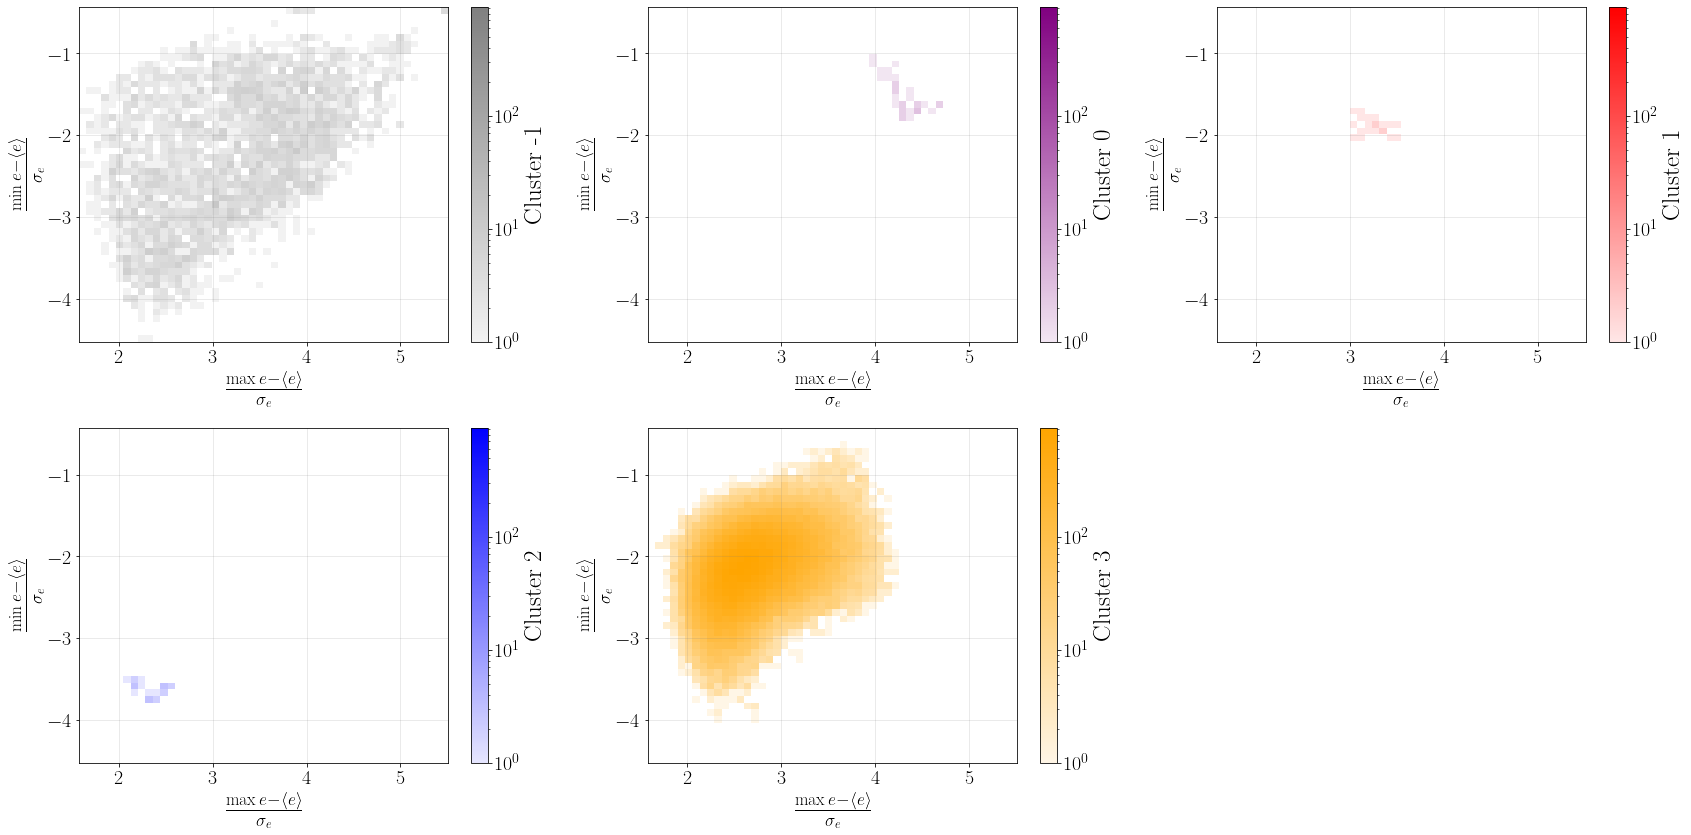

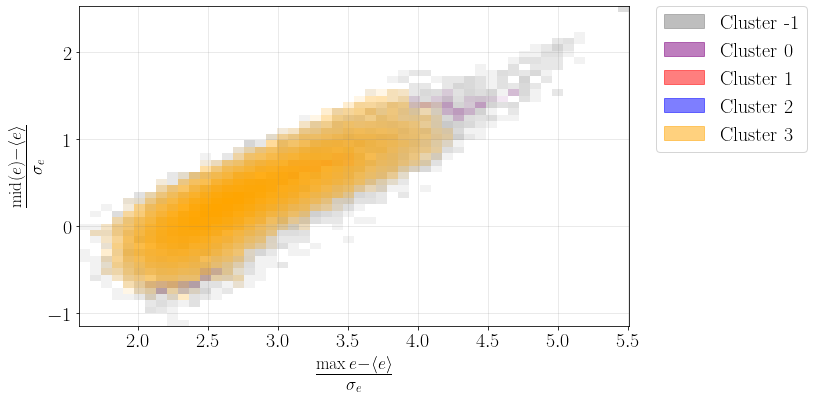

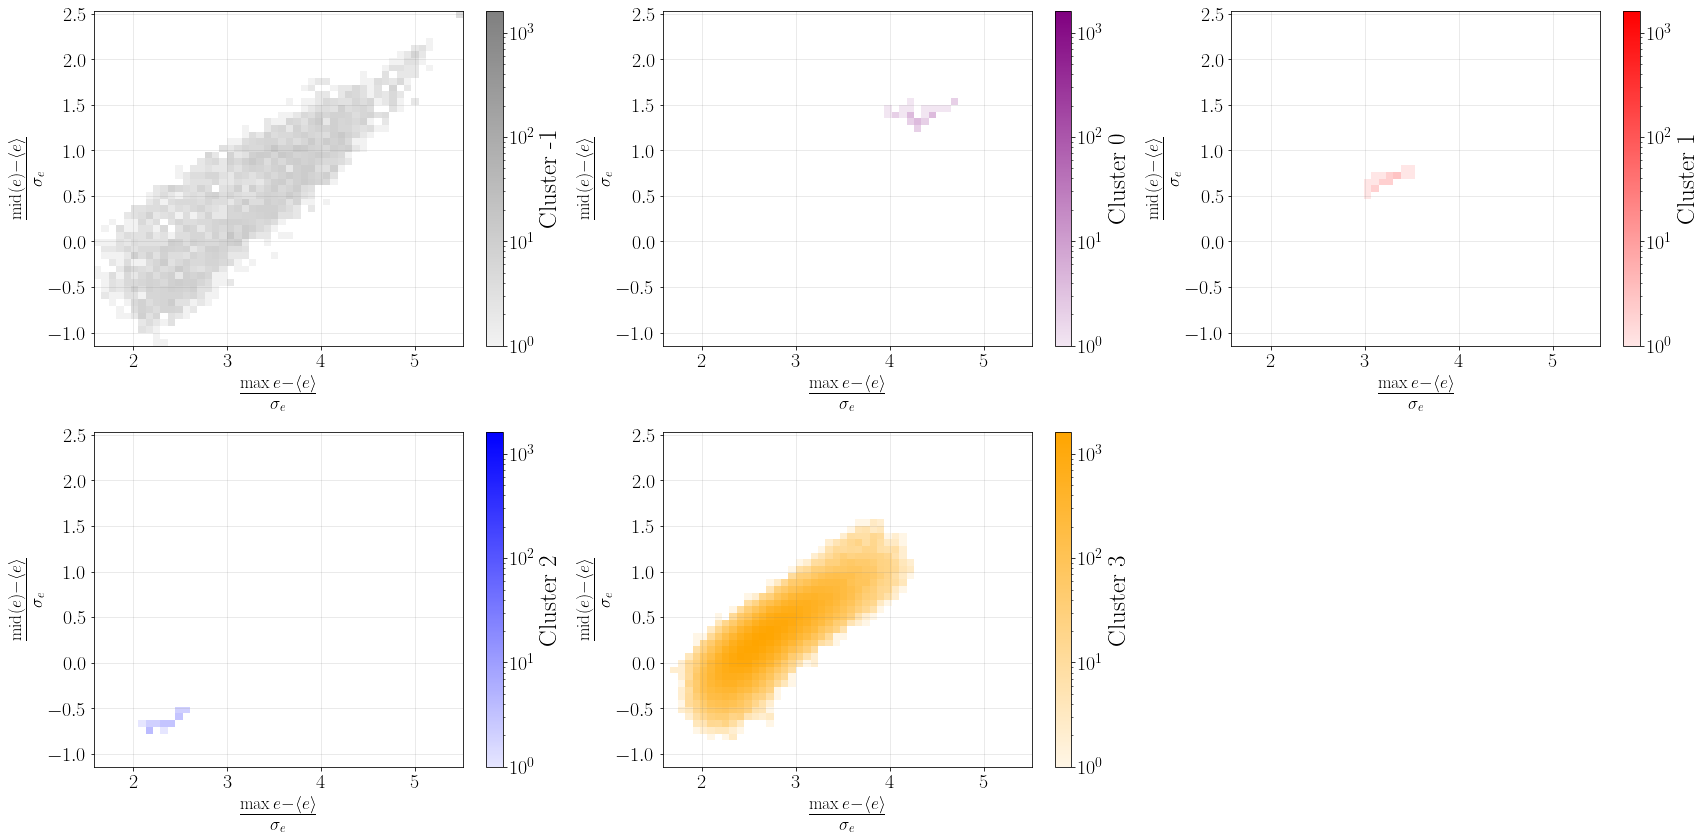

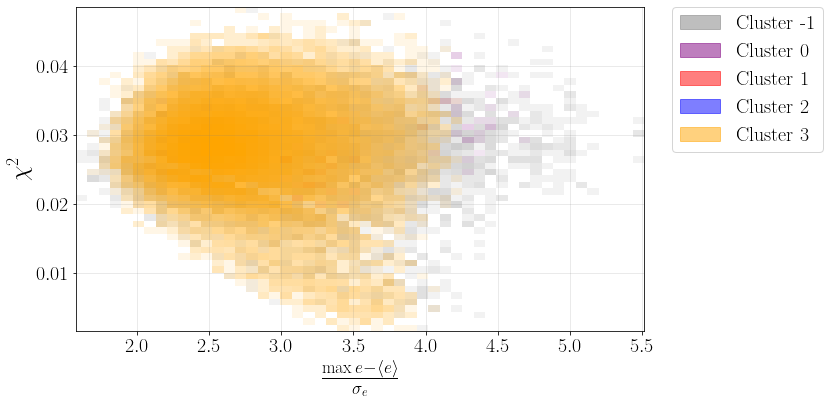

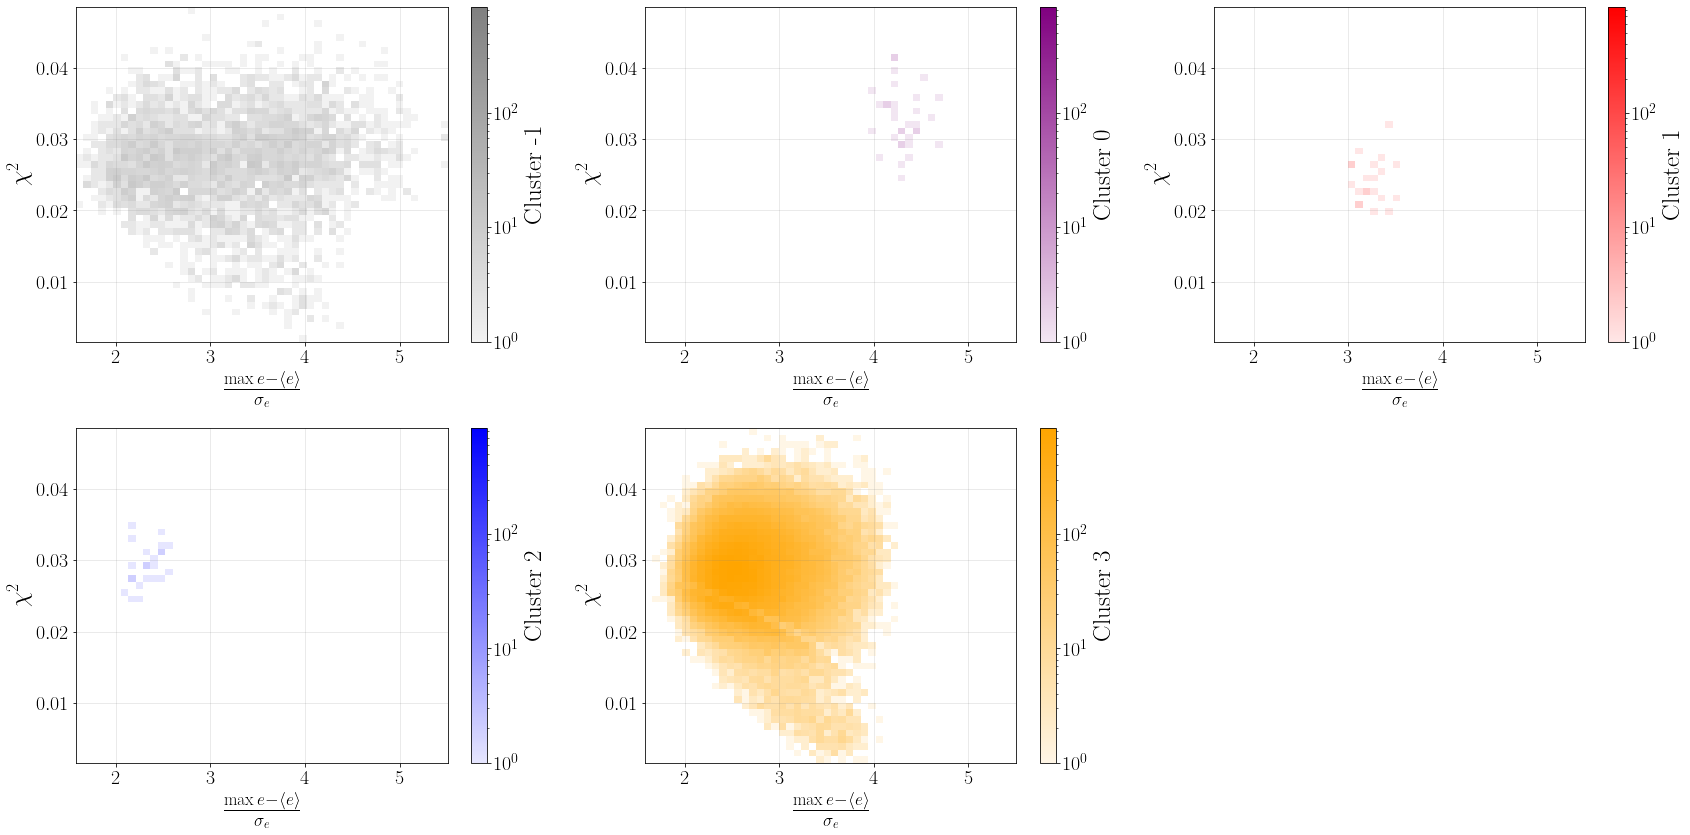

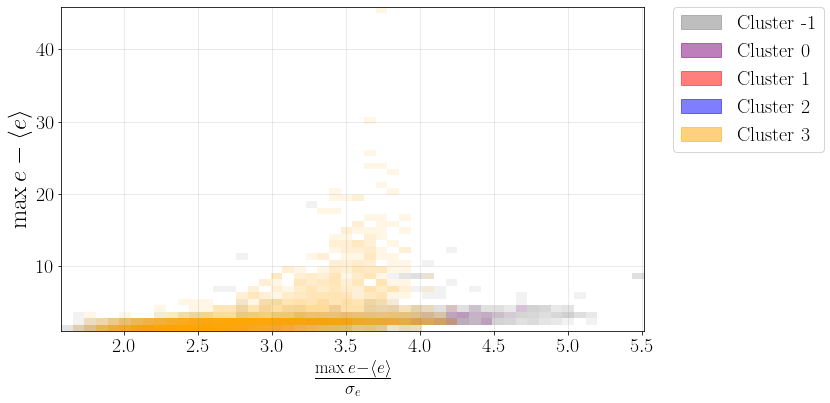

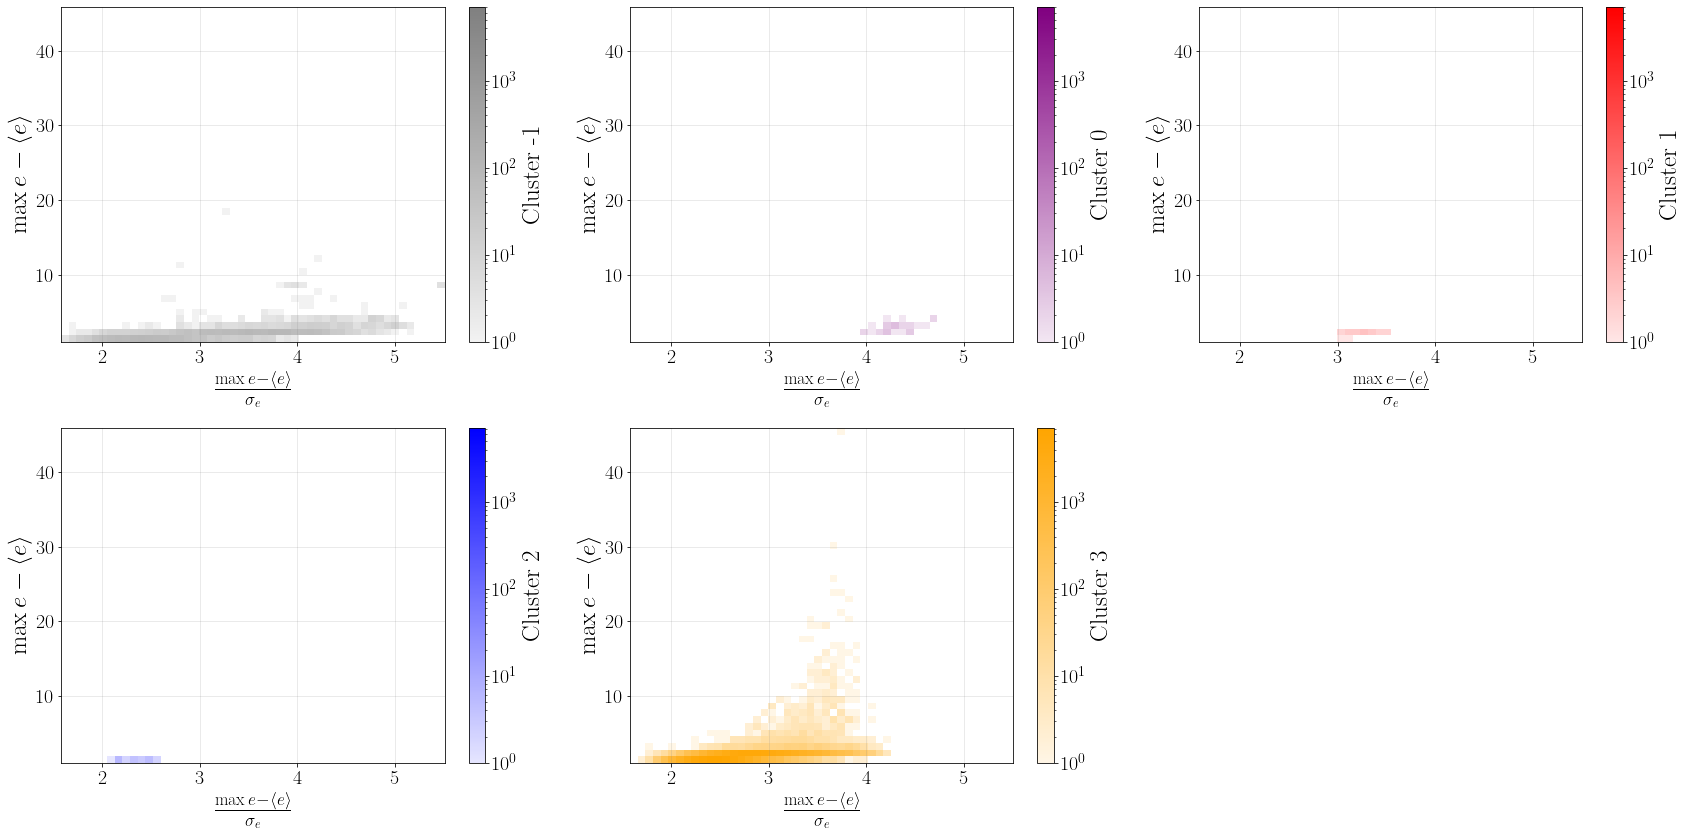

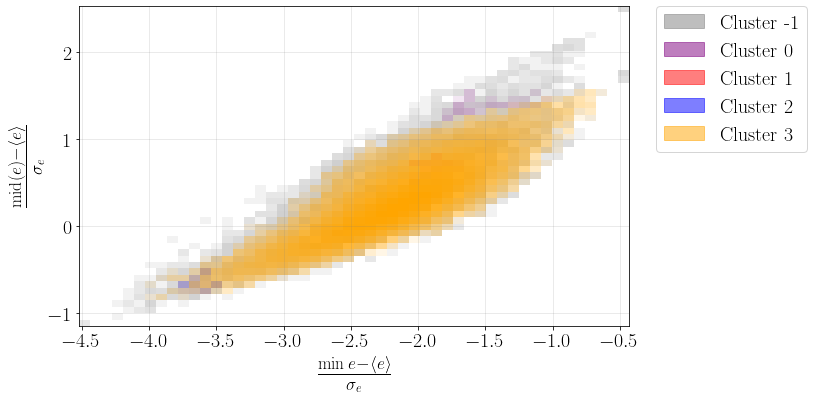

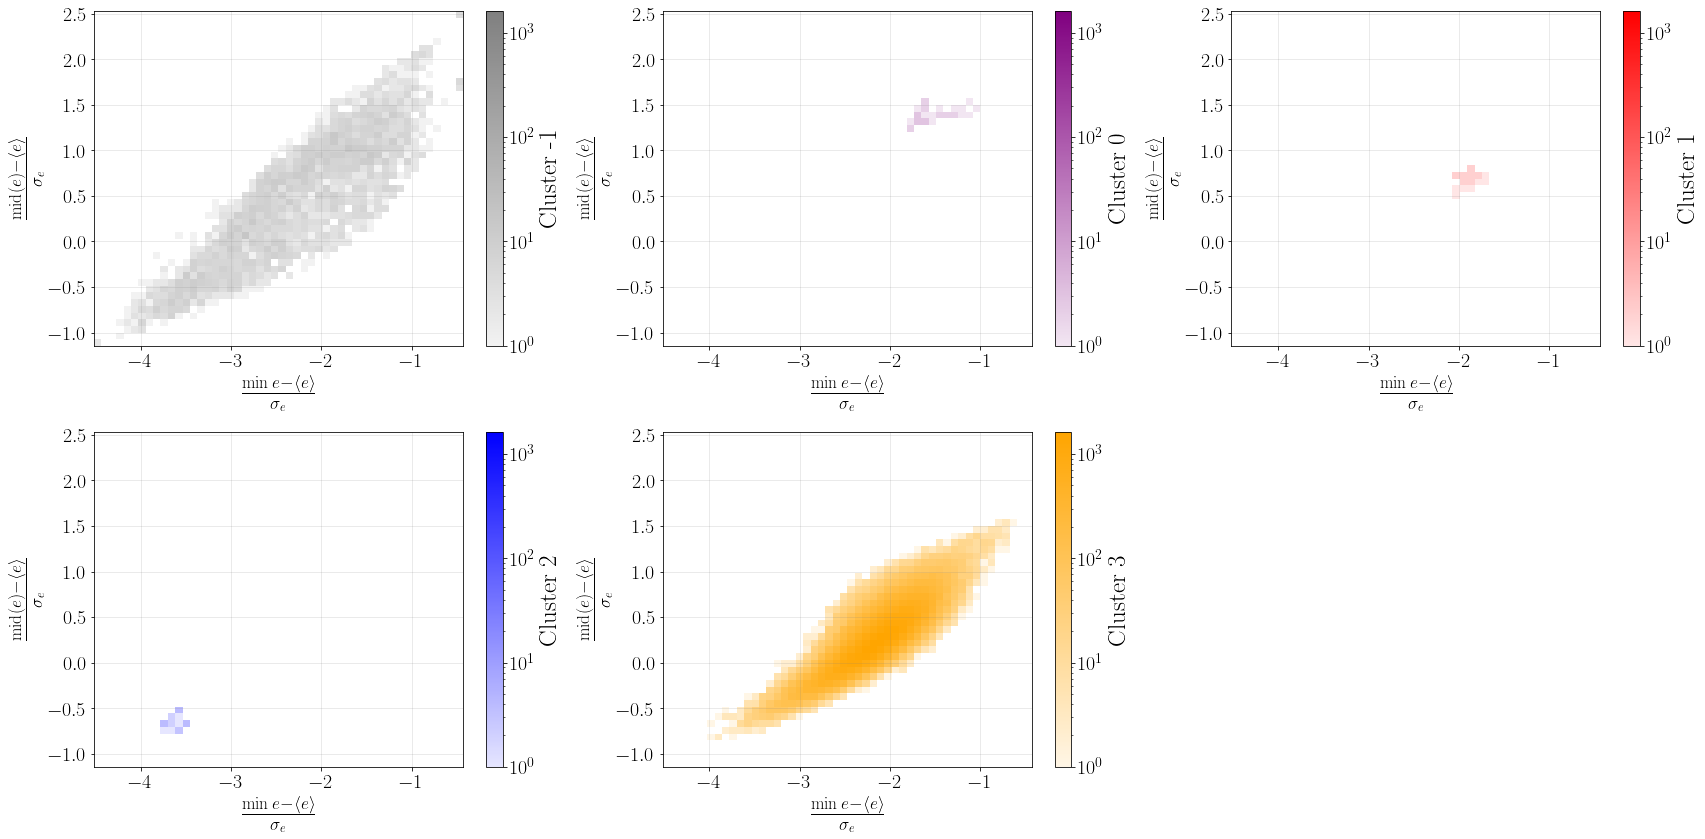

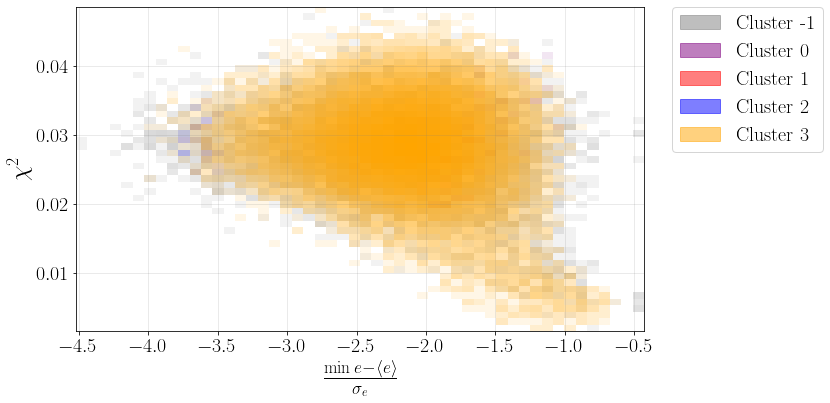

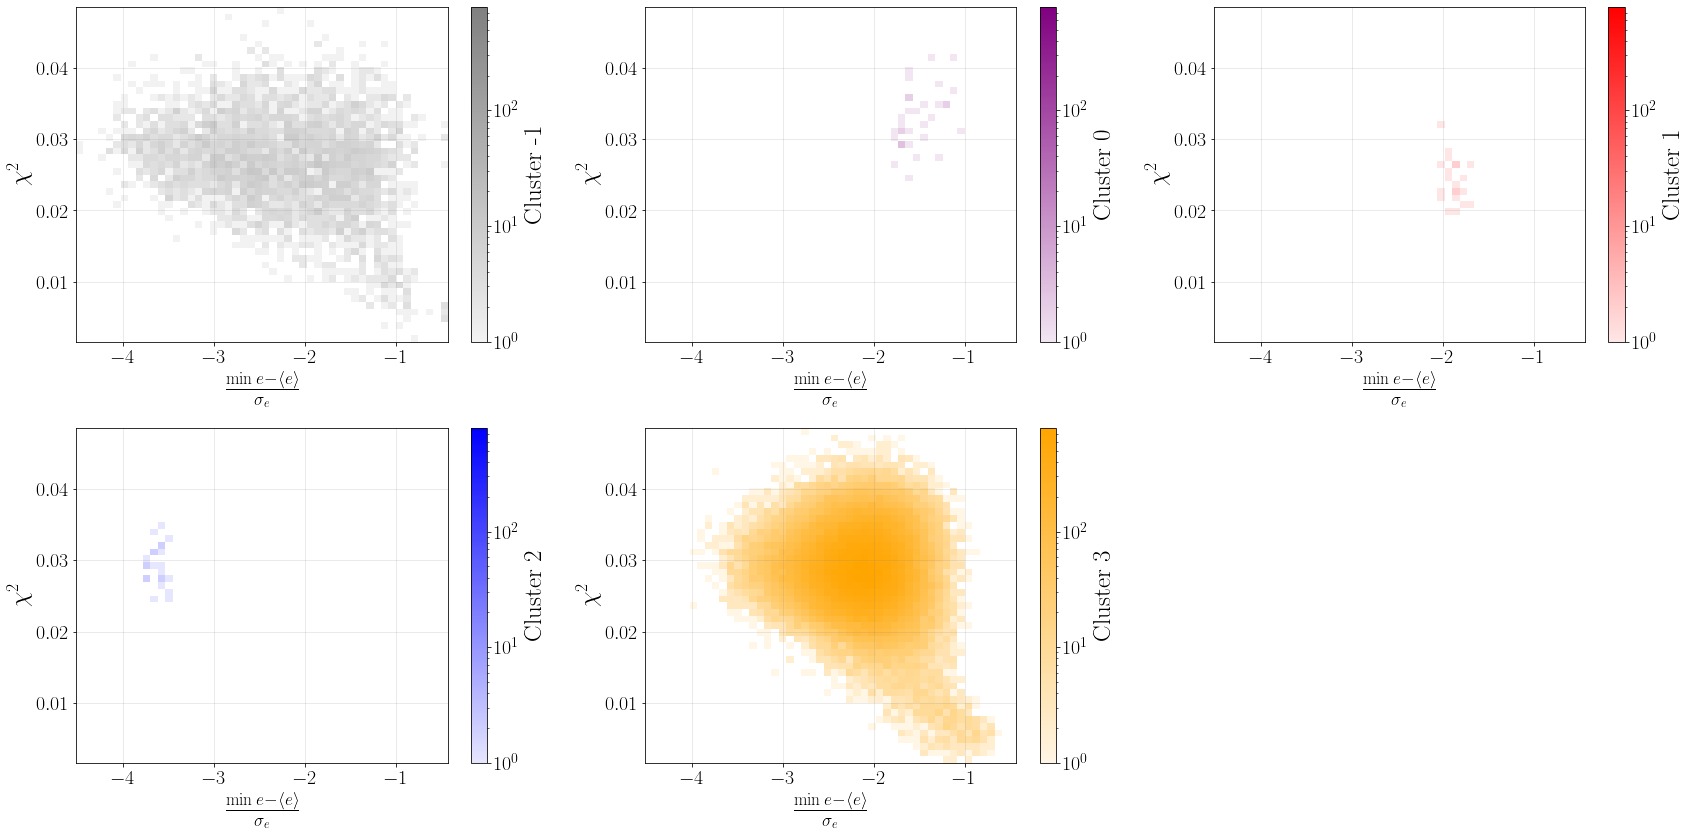

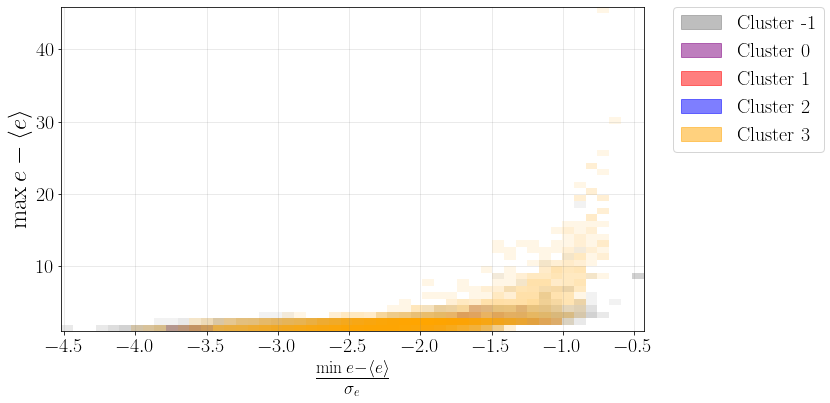

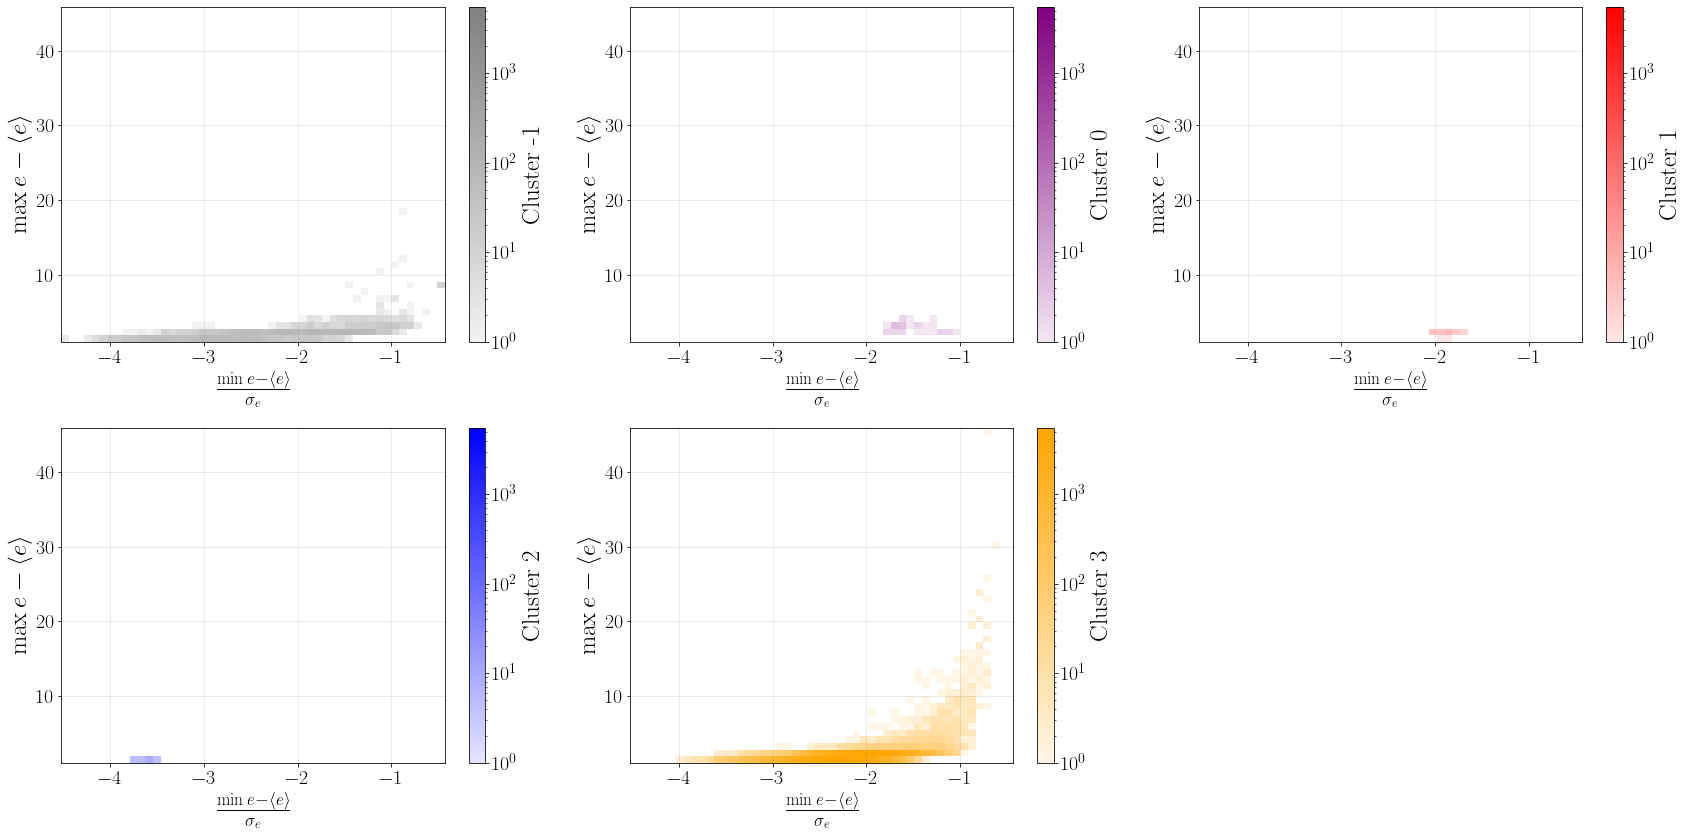

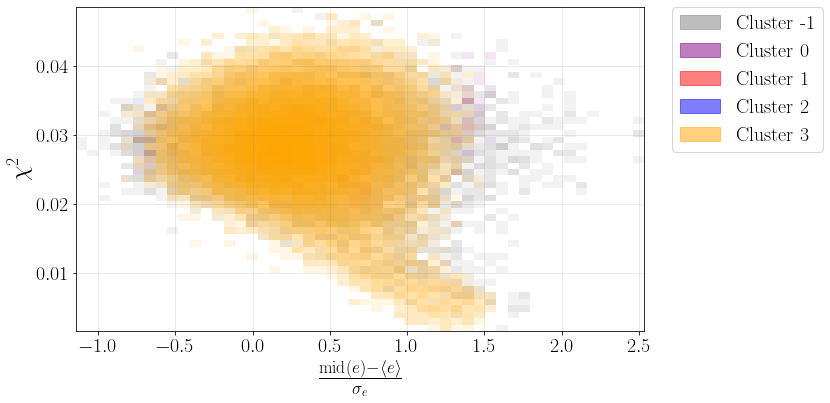

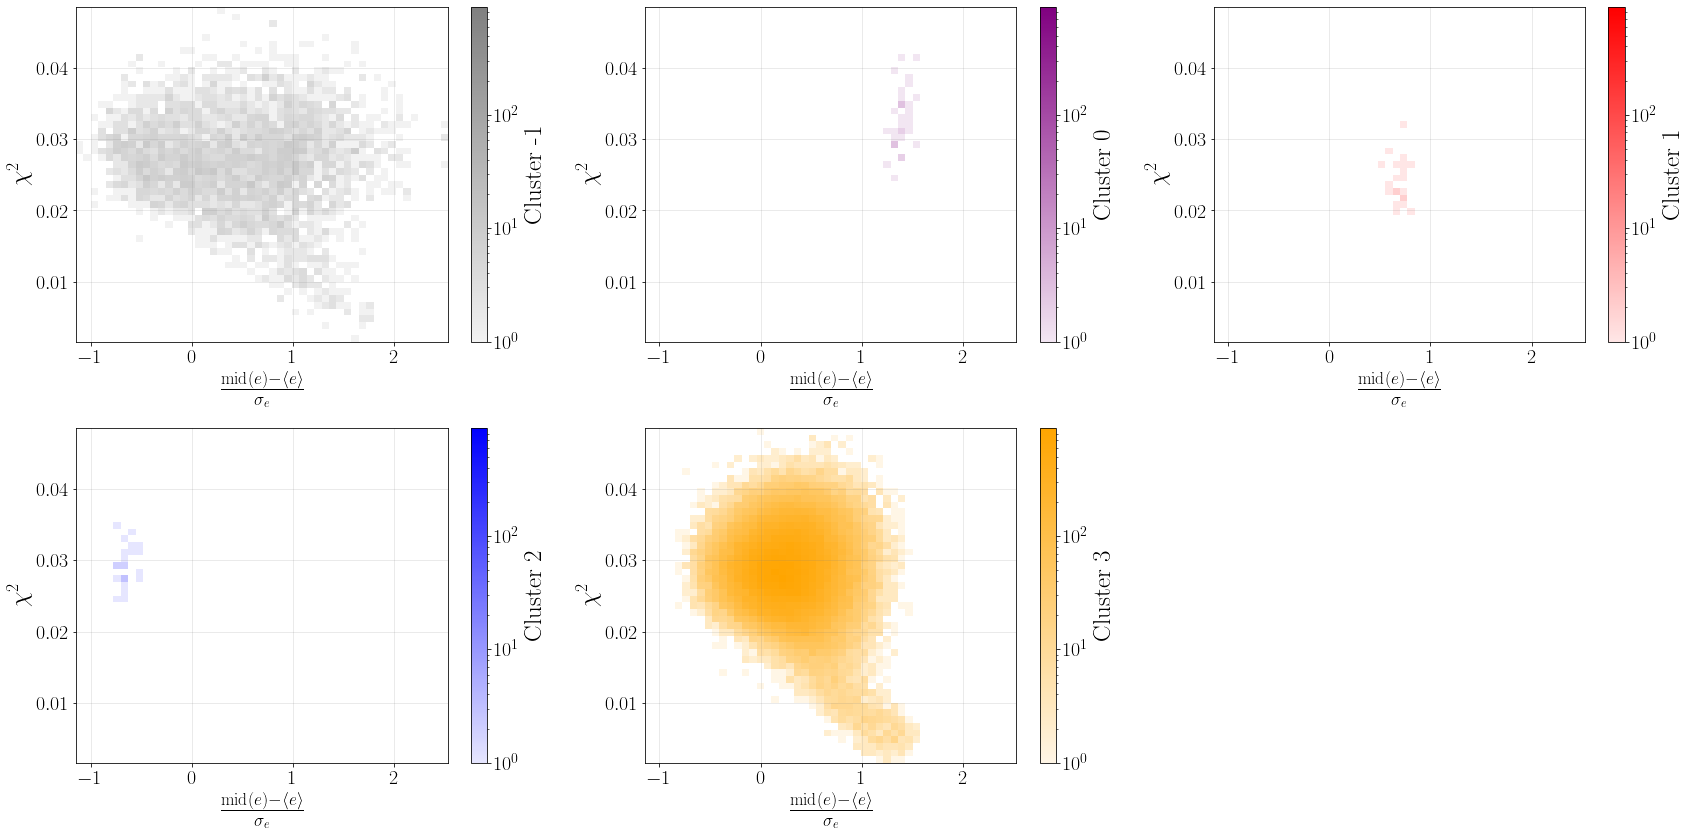

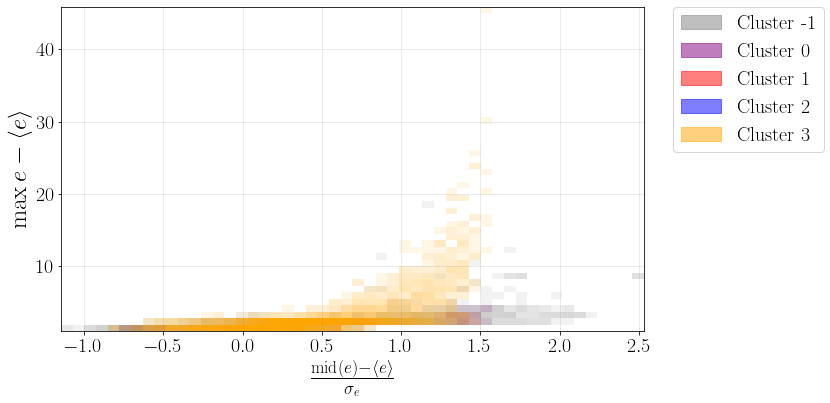

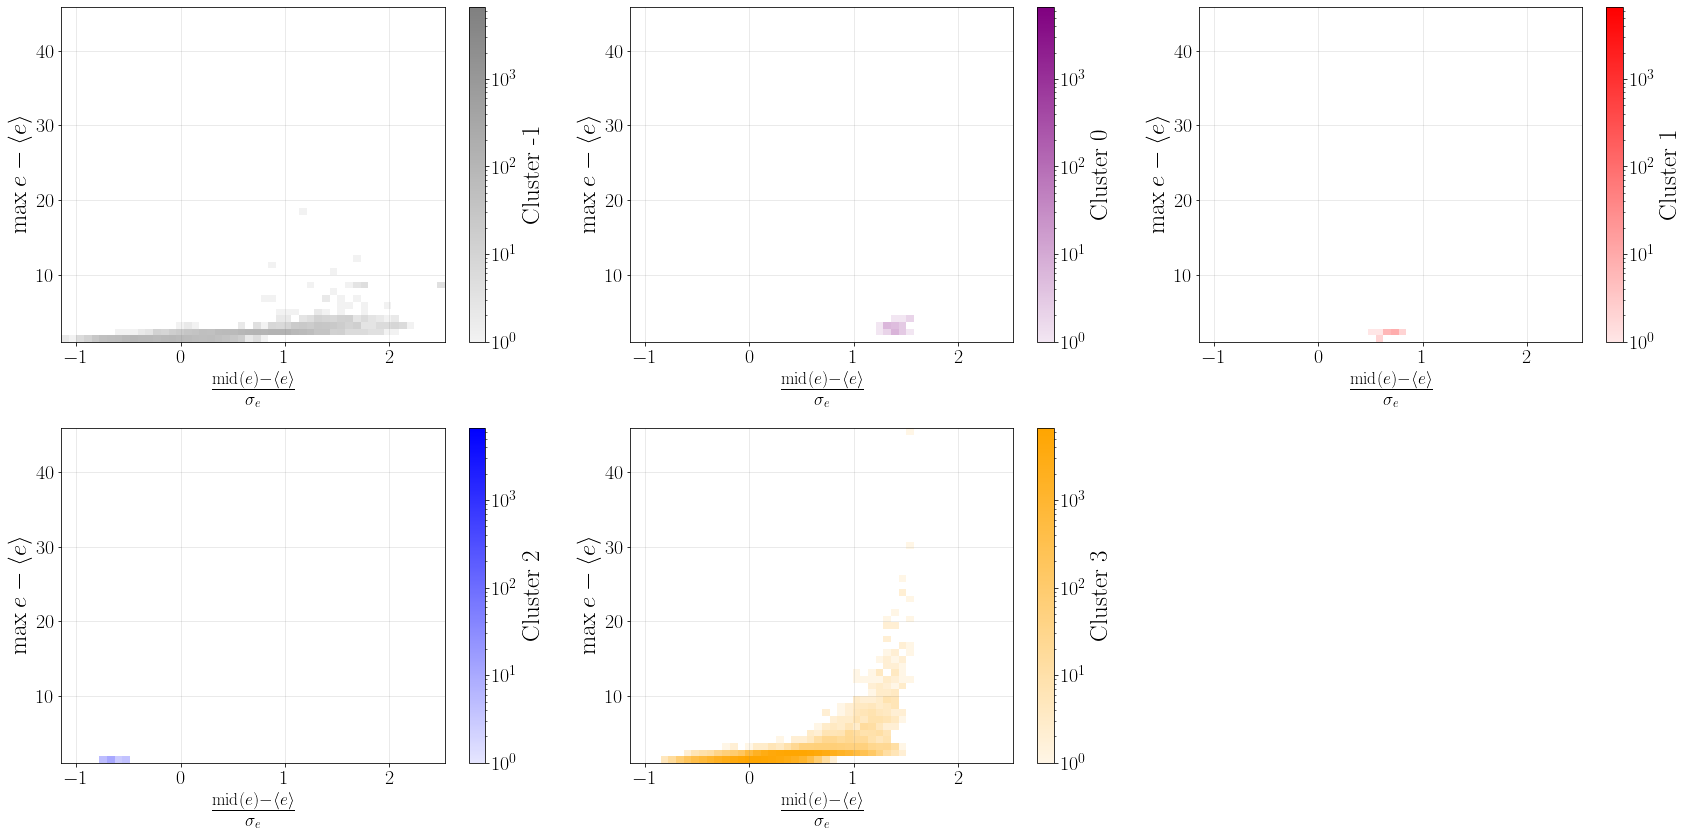

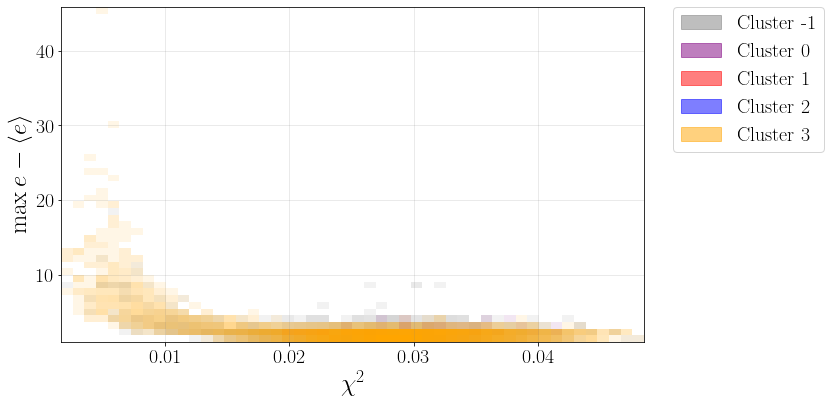

In [51]:
dict_color_clu_labels = {
    -1: 'grey',
    0: 'purple',
    1: 'r',
    2: 'b',
    3: 'orange',
    4: 'g', 
    5: "darkolivegreen",
    6: 'aqua',
    7: 'sienna',
    8: 'darkgoldenrod',
    9: 'lime',
    10: 'gold',
    11: 'crimson',
    12: 'indigo',
    13: 'salmon',
    14: 'maroon',
    15: 'black',
}



clustering.plot_clusters_hist2d(
    dataframe, 
    features + ['max_m_mean'],
    column_labels,
    clu_label_name,
    logscale=True,
    dict_color_clu_cats=dict_color_clu_labels
)

### Analysis of the result

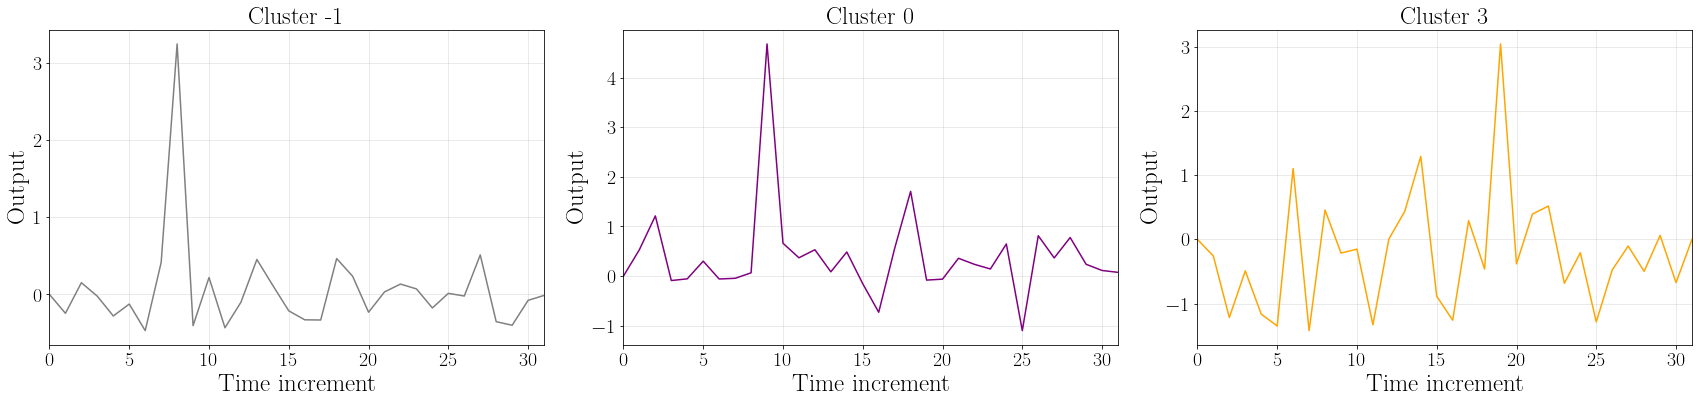

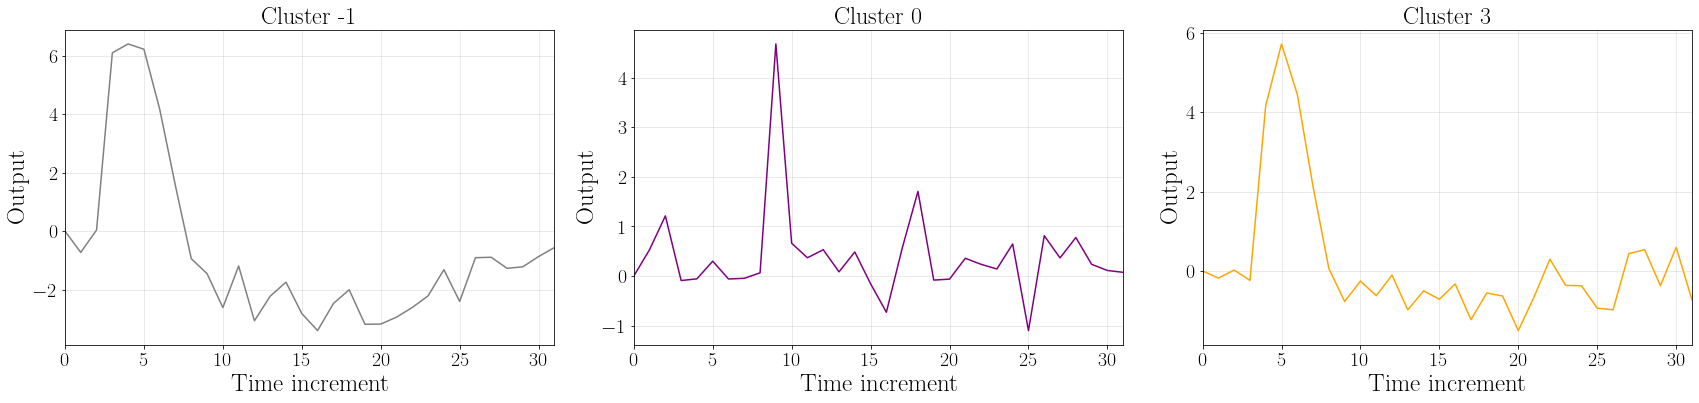

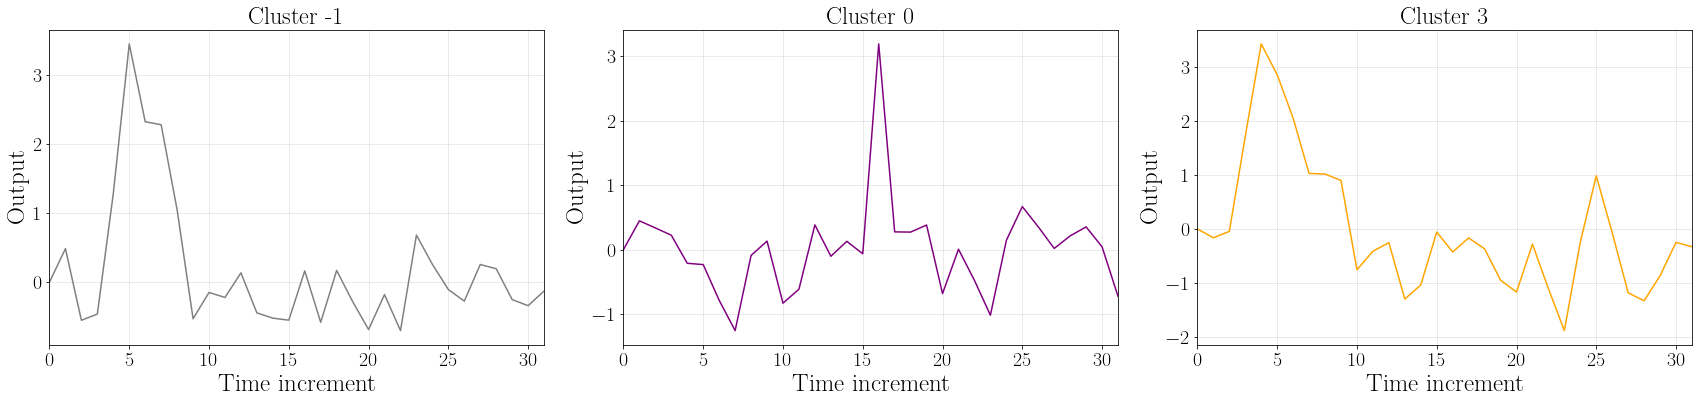

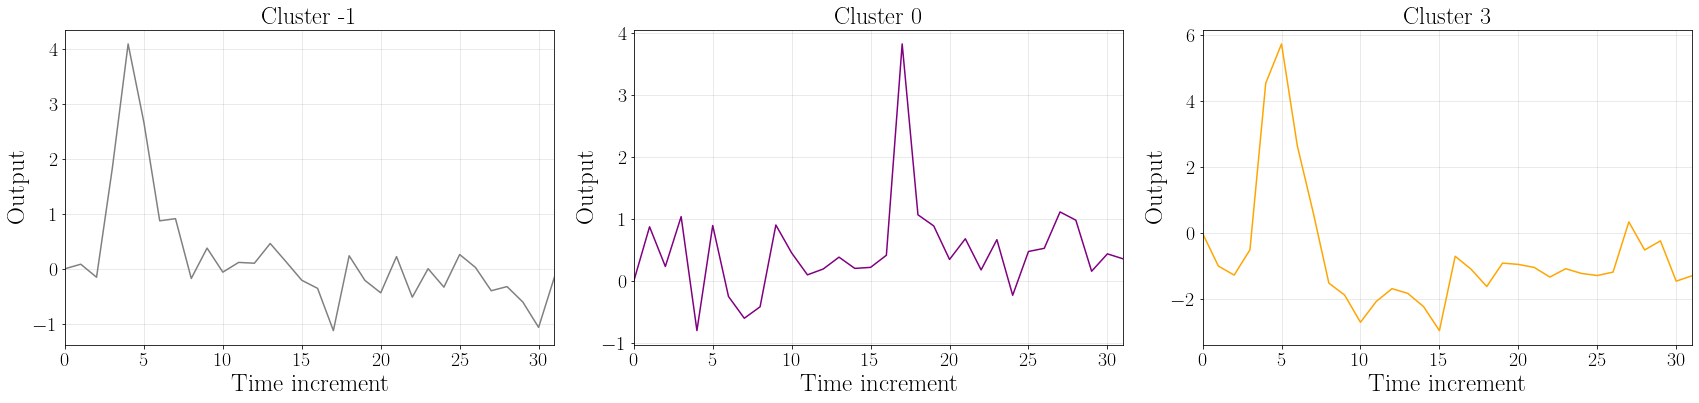

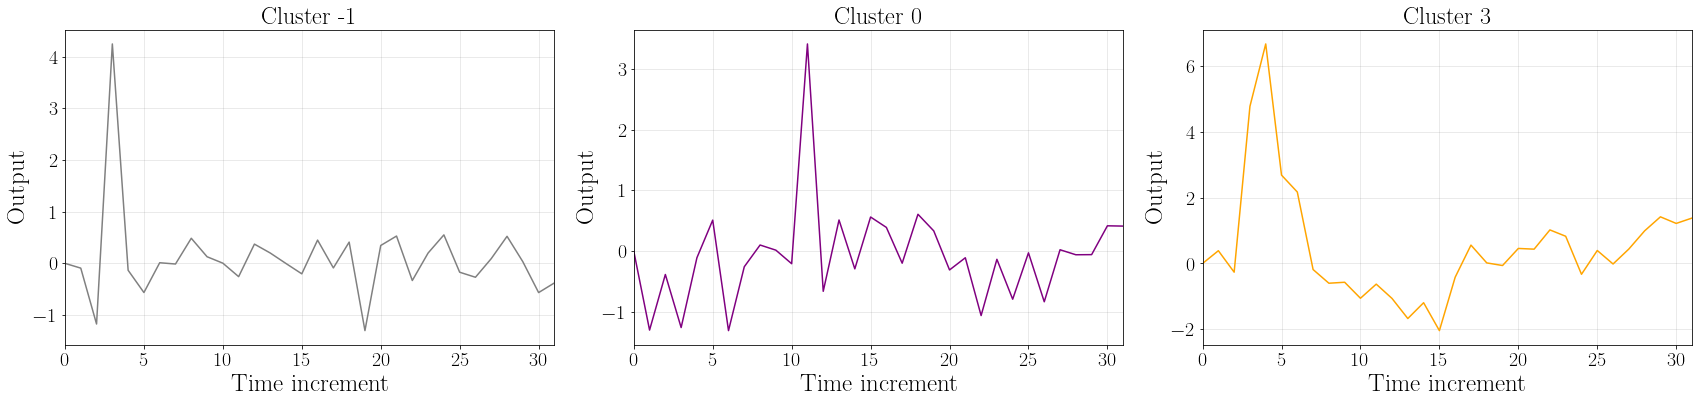

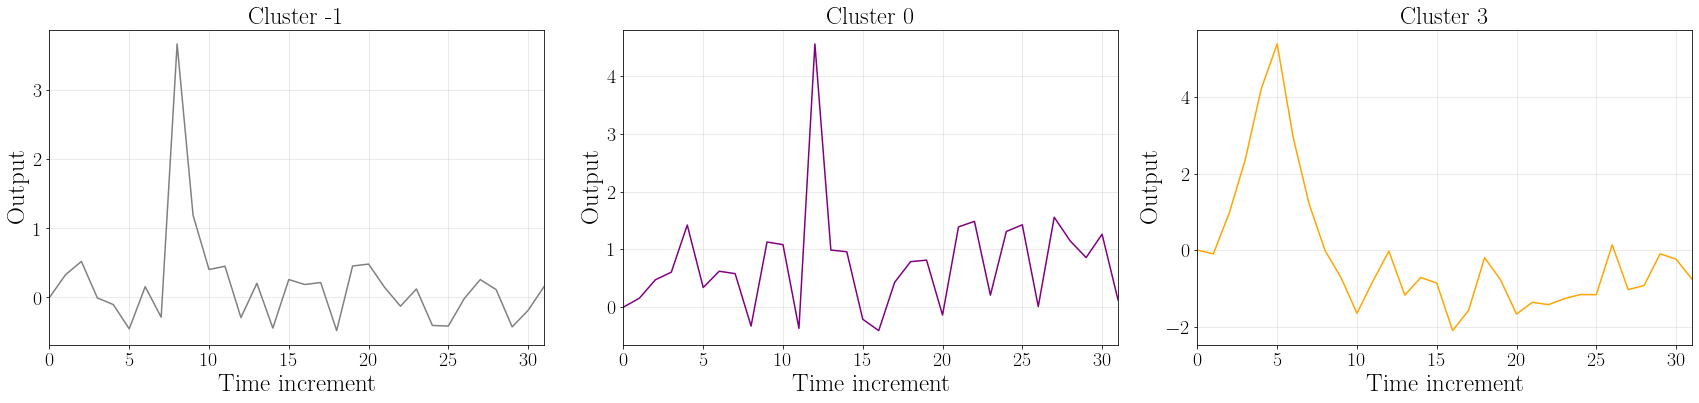

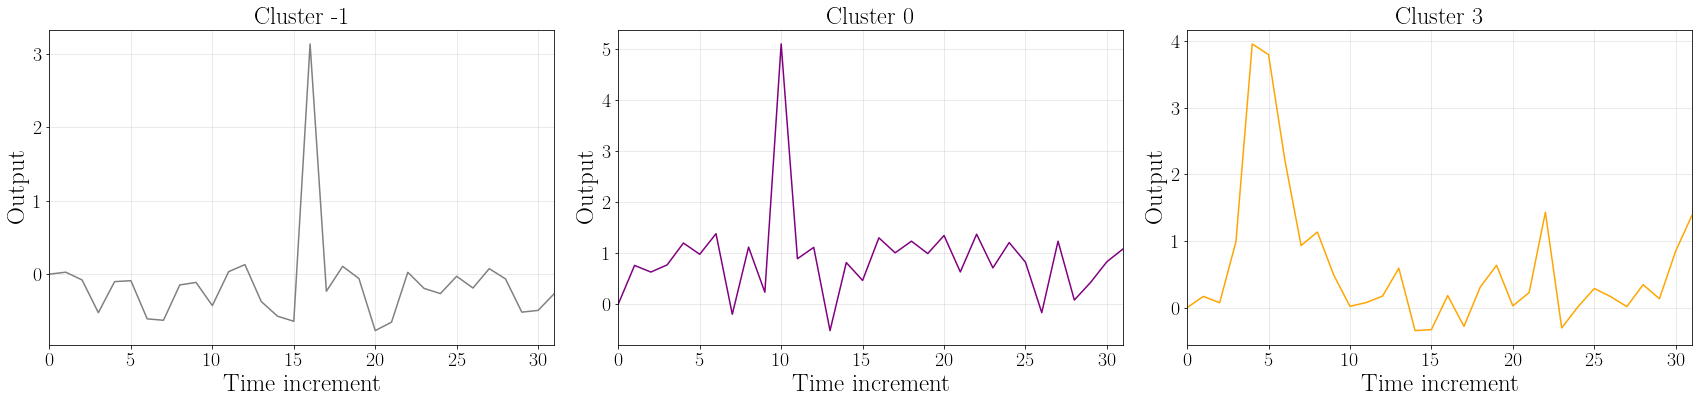

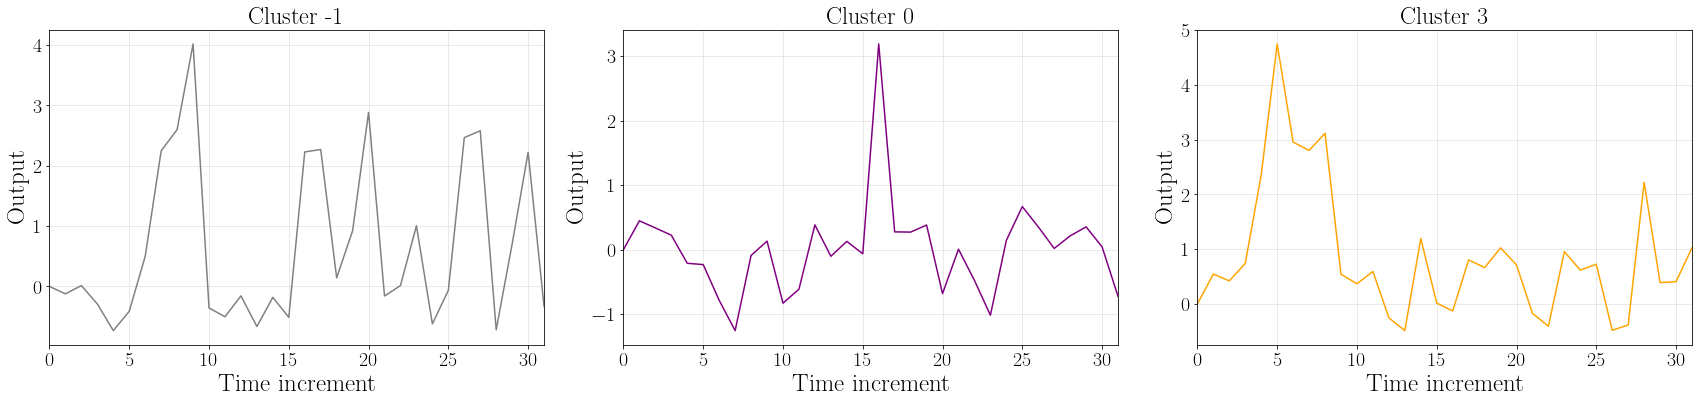

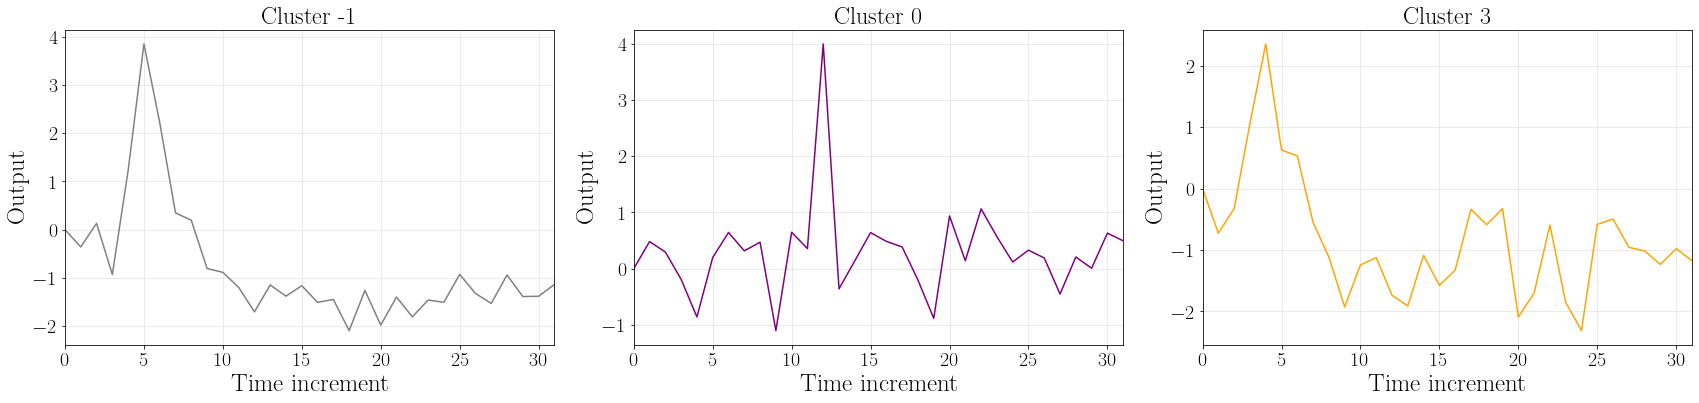

In [52]:
for i in range(10):
    clustering.plot_samples_clusters(
        dataframe.query('max_m_mean > 3.'),
        clu_label_name,
        dict_color_clu_labels=dict_color_clu_labels
    )

### K-means

In [11]:
from sklearn.cluster import KMeans, OPTICS

In [12]:
clu_label_name = "kmeans_SN"
clu_label_alias = "Signal vs Noise k-means"

In [19]:
features = ["mean_before_end_peak", "mean_after_end_peak", "pos_max", "mean_m_pedestal"]
kmeans = KMeans(
    init="k-means++", #algorithm="elkan",
    n_clusters=2, random_state=rng.integers(2**32)
)
kmeans = kmeans.fit(dataframe_filtered[features])
dataframe_filtered[clu_label_name] = kmeans.labels_


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='Signal vs Noise k-means', ylabel='Number of events'>)

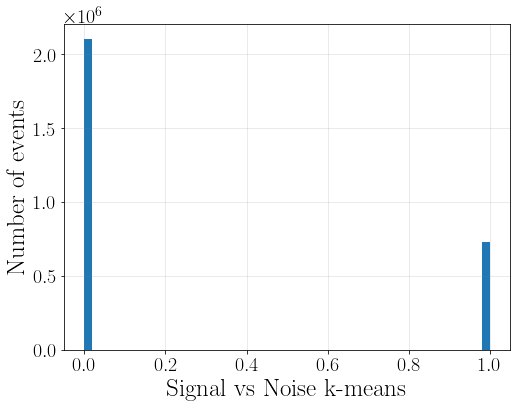

In [20]:
lp.plot_hist(
    dataframe_filtered[clu_label_name],
    clu_label_alias
)

In [15]:
list_cat_labels = np.unique(kmeans.labels_)

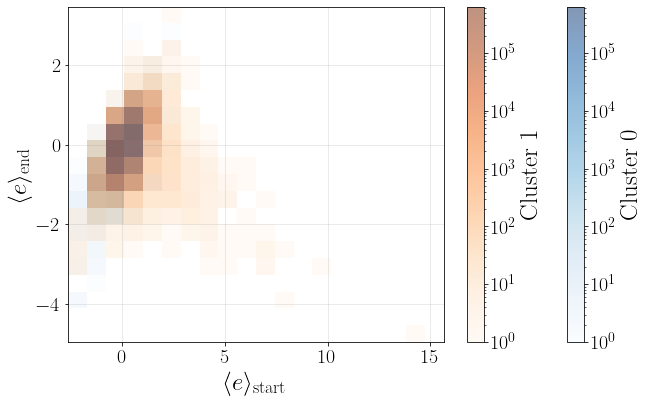

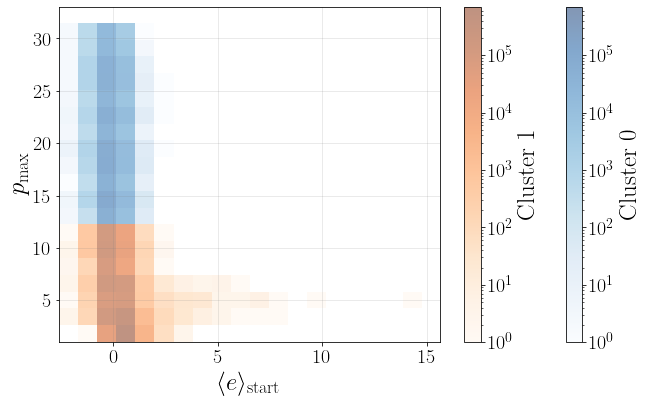

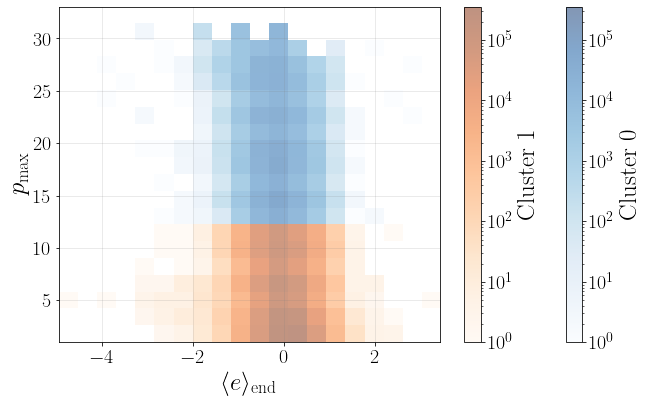

In [16]:
for name_var1, name_var2 in itertools.combinations(features, 2):

    list_var1, list_var2 = [], []
    list_labels = []
    list_df = []

    for cat_label in list_cat_labels:
        df_cat = dataframe_filtered.query(f"{clu_label_name} == {cat_label}")
        list_var1.append(df_cat[name_var1])
        list_var2.append(df_cat[name_var2])
        list_labels.append(f"Cluster {cat_label}")
        list_df.append(df_cat)
    cmap = ["Blues", "Oranges"]


    lp.multi_plot_hist2d(
            list_var1, list_var2,
            column_labels[name_var1], column_labels[name_var2],
            list_labels,    
            one_ax=True,
            cmap=cmap,
            logscale=True,
            bins=20
        )

### OPTICS

In [26]:
from sklearn.cluster import OPTICS

In [27]:
clu_label_name = "OPTICS_SN"
clu_label_alias = "Signal vs Noise OPTICS"

In [28]:
features = ["mean_before_end_peak", "mean_after_end_peak", "pos_max", "mean_m_pedestal"]
optics = OPTICS(
    min_samples=5
)
optics = optics.fit(dataframe_filtered[features])
dataframe_filtered[clu_label_name] = optics.labels_


In [33]:
dataframe_filtered.iloc[84]['min_std_pos_neg_redpn']

0.22772999919644132

(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='Time increment', ylabel='Output'>)

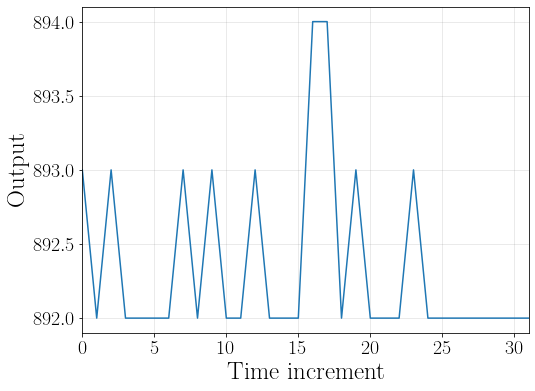

In [32]:
lp.plot_event(dataframe_filtered.iloc[84])

In [ ]:
list_cat_labels = np.unique(kmeans.labels_)

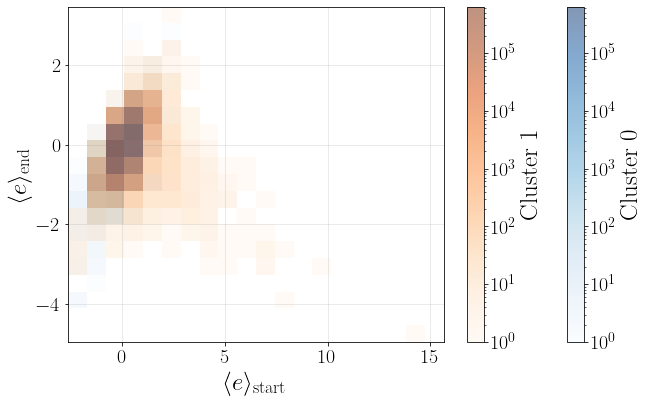

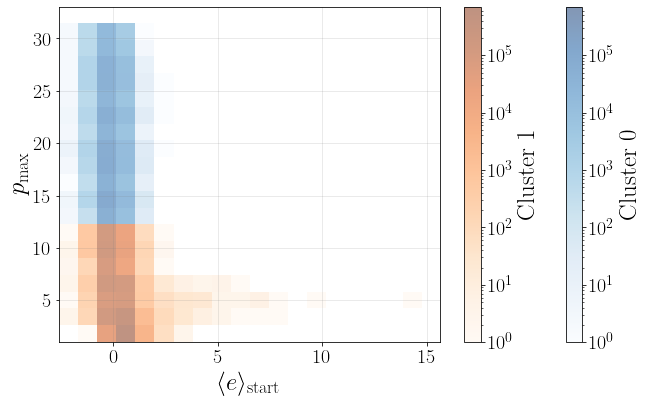

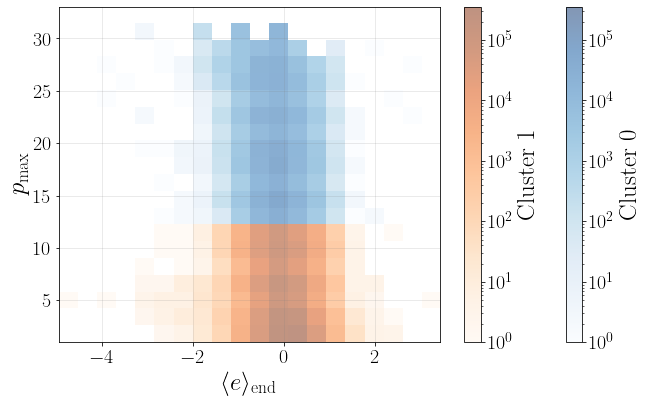

In [ ]:
for name_var1, name_var2 in itertools.combinations(features, 2):

    list_var1, list_var2 = [], []
    list_labels = []
    list_df = []

    for cat_label in list_cat_labels:
        df_cat = dataframe_filtered.query(f"{clu_label_name} == {cat_label}")
        list_var1.append(df_cat[name_var1])
        list_var2.append(df_cat[name_var2])
        list_labels.append(f"Cluster {cat_label}")
        list_df.append(df_cat)
    cmap = ["Blues", "Oranges"]


    lp.multi_plot_hist2d(
            list_var1, list_var2,
            column_labels[name_var1], column_labels[name_var2],
            list_labels,    
            one_ax=True,
            cmap=cmap,
            logscale=True,
            bins=20
        )